In [1]:
# !pip install --upgrade pip

import os
from joblib import Parallel, delayed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
from sklearn.svm import OneClassSVM
from dataclasses import asdict
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns


# Global utitlity functions are in separate notebook
%run ./Classification_utility-functions.ipynb
%run ./SEED-CONSTANTS.ipynb

np.random.seed(SEED)
print(f"Numpy Seed was set to: {SEED}")

print("Setup Complete")

SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Neu

In [2]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Parameter set. Used as identifier for charts etc.
    frequency: int
    max_subjects: int
    max_test_subjects: int
        
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
    
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    window_size: int  # After resampling
    ocsvm_step_width: int  # After resampling
    scaler: str  # StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # fit transform scale on all data (True) or fit on training only (False)
    ocsvm_kernel: str # ocsvm kernel
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model
    feature_cols: list  # Columns used as features
    exclude_subjects: list  # Don't load data from those users
        
    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        

# INSTANCES
# ===========================================================

# NAIVE_APPROACH
# -----------------------------------------------------------
NAIVE_MINMAX_OCSVM = ExperimentParameters(
    name="NAIVE-MINMAX_OCSVM",
    frequency=100,
    max_subjects=29,
    max_test_subjects=10,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    seconds_per_subject_train=210,
    seconds_per_subject_test=210,    
    window_size=250,
    ocsvm_step_width=250,
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    ocsvm_kernel="rbf",
    ocsvm_nu=None,
    ocsvm_gamma=None,
    feature_cols=[
        "x_a",
        "y_a",
        "z_a",
        "x_g",
        "y_g",
        "z_g",
    ],
    exclude_subjects=[],
)

# VALID_APPROACH
# -----------------------------------------------------------
VALID_MINMAX_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-MINMAX-OCSVM",
    scaler_global=False,
    ocsvm_nu=0.165,
    ocsvm_gamma=0.039,
)

# NAIVE_ROBUST_APPROACH
# -----------------------------------------------------------
NAIVE_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="NAIVE-ROBUST-OCSVM",
    scaler="robust",
    scaler_global=True,
    ocsvm_nu=0.153,
    ocsvm_gamma=0.091,  # below median, selected by chart
)

# ROBUST_APPROACH (VALID)
# -----------------------------------------------------------
VALID_ROBUST_OCSVM_125 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=125
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)


VALID_ROBUST_OCSVM_250 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=250
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_500 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=500
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_750 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=750
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1000 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1000
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1250 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1250
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1500 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1500
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1750 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1750
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_2000 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=2000
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

# NORMALIZER_APPROACH (VALID)
# -----------------------------------------------------------
VALID_NORMALIZER_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-NORMALIZER-OCSVM",
    scaler="Normalizer",
    scaler_global=False,
    ocsvm_nu=0.074,
    ocsvm_gamma= 0.029,
)

In [3]:
P = VALID_ROBUST_OCSVM_2000
P.ocsvm_step_width = int(P.window_size * .5)
P.classifier="OCSVM"
# P = VALID_NORMALIZER_OCSVM

In [16]:
style = {
    "figure.figsize": (8, 6),
    "font.family": "serif",  # Ensure that we're using a serif font for LaTeX compatibility
    "text.usetex": True,  # Use LaTeX to format labels and titles    
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 2,
    # "lines.markersize": 8,
    # "lines.marker": 'o',
    # "lines.markerfacecolor": 'none',
    # "lines.markeredgecolor": 'auto',
    # "lines.markeredgewidth": 1.5,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.53,
    "grid.linewidth": 0.8,
    "grid.color": "#D3D3D3",  # A light gray, you can adjust to preference
    "grid.linestyle": "--",
    "axes.facecolor": "white",  # background color of the axes (plotting area)
    "figure.facecolor": "white",  # background color of the figure
    "axes.edgecolor": "#333333",  # color of the borders
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.bottom": True,
    "axes.spines.left": True,
}
markers = ['o', 's', '^', 'v', '<', '>', 'D', 'd', 'p', 'h']


plt.rcParams.update(style)

In [4]:
utils_ppp(P)

,Value
name,VALID-ROBUST-OCSVM
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [5]:
[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49][17]

37

In [6]:
utils_eer_scorer

make_scorer(utils_eer, greater_is_better=False)

# Split Dataset for Valid/Test  
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

They did a 30 60 split.

# Reshaping Raw Features.
We have our own function of windows for this. Do this for both training and testing.

# Extracting time and frequency based features.
Again, we have a function for this. Do this for both training and testing.

# Hyperparameter Optimization 

I do not find any reaqsonable explaination how to use a cross-validation as we are talking about anomaly detection.

I am using the experiment 1 data as train, and experiment 2 data as validation.

# Using SVM in a real-world Scenario with multiple genuine users and intruders
Source: https://datascience.stackexchange.com/questions/23623/what-is-the-best-way-to-classify-data-not-belonging-to-set-of-classes

Stage 1: 
    Use one-class SVM to assign those images that do not belong to the set of predefined classes as the 9-th class.

Stage 2:
    For those images that passes through your filter, let the multi-class SVM assign them to one of the 8 classes.

Loading data:

In [7]:
P.user_ids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 19,
 21,
 22,
 26,
 27,
 28,
 29,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49]

In [8]:
#include 47 later
# user_ids = [9]
df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
dfList_exp1, dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

Loading exp1 data:
1) accel_count: 28388, gyro_count: 31997
2) accel_count: 26010, gyro_count: 28954
3) accel_count: 28227, gyro_count: 31814
4) accel_count: 24860, gyro_count: 26105
5) accel_count: 24270, gyro_count: 24347
6) accel_count: 25012, gyro_count: 25060
7) accel_count: 25301, gyro_count: 25382
8) accel_count: 21975, gyro_count: 21658
19) accel_count: 24110, gyro_count: 25050
21) accel_count: 24326, gyro_count: 23809
22) accel_count: 29123, gyro_count: 28724
26) accel_count: 23148, gyro_count: 24291
27) accel_count: 24299, gyro_count: 23589
28) accel_count: 23807, gyro_count: 24523
29) accel_count: 24030, gyro_count: 23457
35) accel_count: 24388, gyro_count: 23673
36) accel_count: 24228, gyro_count: 24208
37) accel_count: 31945, gyro_count: 31816
38) accel_count: 22135, gyro_count: 22327
39) accel_count: 23573, gyro_count: 23459
40) accel_count: 23057, gyro_count: 24296
41) accel_count: 24102, gyro_count: 23681
42) accel_count: 24074, gyro_count: 24328
43) accel_count: 22631,

In [9]:
raw_dfList_exp1 = dfList_exp1
raw_dfList_exp2 = dfList_exp2

<AxesSubplot:>

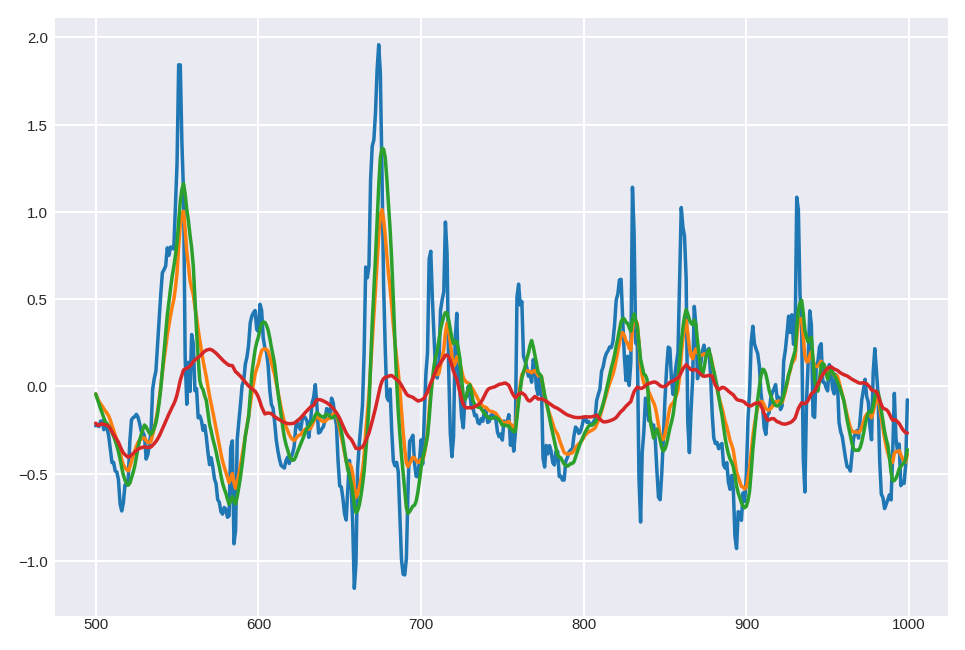

In [10]:
P.span=15
P.smoothing = "FFT+EMA"
# raw_dfList_exp1 = dfList_exp1
# raw_dfList_exp2 = dfList_exp2
P.cut_off_freq=42
ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2[0]['x_a'][500:1000].plot()
EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=P.span)
EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
EMAed_dfList_exp2[0]['x_a'][500:1000].plot()

dfList_exp1 = ffted_dfList_exp1
dfList_exp2 = ffted_dfList_exp2

dfList_exp1 =EMAed_dfList_exp1
dfList_exp2 =EMAed_dfList_exp2

SMAed_dfList_exp1 = get_SMAed_dfList(ffted_dfList_exp1, winsize=10)
SMAed_dfList_exp2 = get_SMAed_dfList(ffted_dfList_exp2, winsize=10)
SMAed_dfList_exp2[0]['x_a'][500:1000].plot()

raw_dfList_exp2[0]['x_a'][500:1000].rolling(window=50, min_periods=0).mean().plot()

In [11]:
randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
split_idx = 2 * (len(randomized_data_idx)//3) + 1
train_set = randomized_data_idx[: split_idx]
test_set = randomized_data_idx[split_idx: ]
print(f"train_set: {train_set}\ntest_set: {test_set}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


Loading exp1 data:
47) accel_count: 22777, gyro_count: 22226
Loading exp2 data:
47) accel_count: 17718, gyro_count: 18353


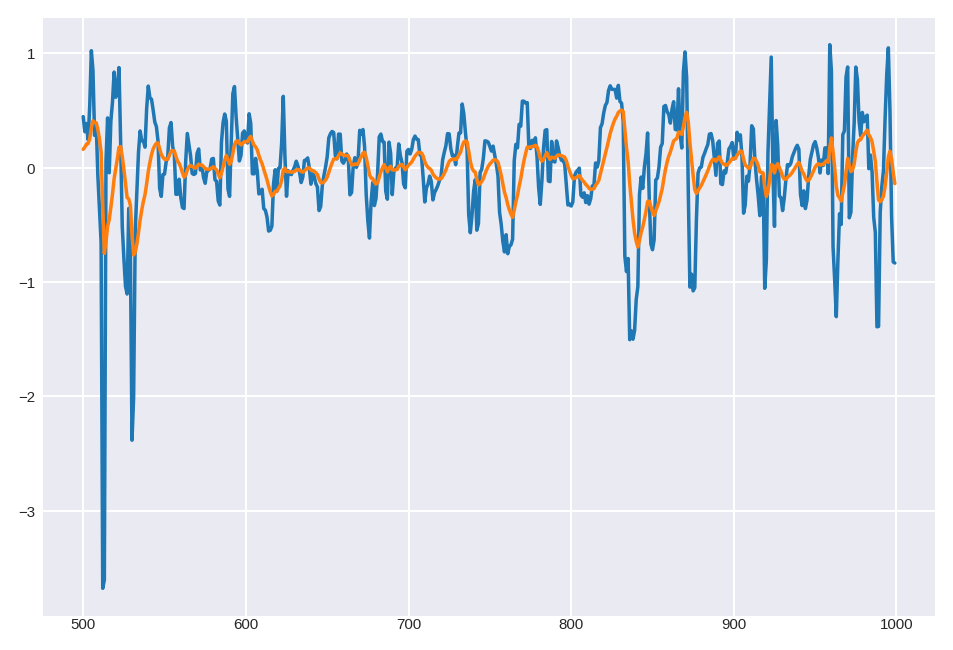

SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
user_47_idx: 29
np.unique(all_user_set): [ 1  2  3  4  5  6  7  8 19 21 22 26 27 28 29 35 36 37 38 39 40 41 42 43
 44 45 46 48 49]
X_exp1_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
X_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 

In [12]:
num_sample_points_per_exp_user_47 = 18000
df_exps_dict_user_47 = load_data_frames([47], P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

raw_dfList_exp1_user_47 = dfList_exp1_user_47
raw_dfList_exp2_user_47 = dfList_exp2_user_47

ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47[0]['x_a'][500:1000].plot()

dfList_exp1_user_47 = ffted_dfList_exp1_user_47
dfList_exp2_user_47 = ffted_dfList_exp2_user_47

EMAed_dfList_exp1_user_47 = get_EMAed_dfList(ffted_dfList_exp1_user_47, span=P.span)
EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
EMAed_dfList_exp2_user_47[0]['x_a'][500:1000].plot()

dfList_exp1_user_47 = EMAed_dfList_exp1_user_47
dfList_exp2_user_47 = EMAed_dfList_exp2_user_47

%run ./utility-functions.ipynb


# preparing train data
X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, P.window_size, P.ocsvm_step_width, train_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, P.window_size, P.ocsvm_step_width, 
                                                                                                                    scaler=P.scaler, num_sample_points_per_exp=P.num_sample_points_per_exp, 
                                                                                                                    EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, P.user_ids, 
                                                                                           X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47, verbose=1)

print(f"len(exp1_df_train_dict): {len(X_train_exp1_dict)}")
print(f"len(exp2_df_train_dict): {len(X_train_exp2_dict)}")


# preparing test data
X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, P.window_size, P.ocsvm_step_width, test_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

print(f"len(X_test_exp1_dict): {len(X_test_exp1_dict)}")
print(f"len(X_test_exp2_dict): {len(X_test_exp2_dict)}")

In [13]:
P.Butter_per_win_argdict={
                        "filter_order": 10,
                        "cut_off_freq": 33,
                        "sampling_freq": 100,
                        "filtfilt": 1,
                        }
P.Butter_per_win_argdict=None
EMA_per_win_span=None
SMA_per_win_winsize=None
fitted_scaler_train_exp2_dict_user_47
fitted_scaler_train_exp2_dict

# pd.set_option('display.max_rows', 50)
P.ocsvm_kernel="rbf"
P.classifier="OCSVM"
P.scaler_clip=False


P.overlap=.5
P.window_size=1000
P.step_width = int(P.window_size * (1-P.overlap))
P.ocsvm_step_width=P.step_width
train_set=THREE_FOLD_CV[0][0]

dfList_exp1=raw_dfList_exp1
dfList_exp2=raw_dfList_exp2
dfList_exp1_user_47=raw_dfList_exp1_user_47
dfList_exp2_user_47=raw_dfList_exp2_user_47
X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(raw_dfList_exp1, raw_dfList_exp2, P.window_size, P.step_width, train_set, P.scaler, P.num_sample_points_per_exp, 
                                                                                    EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize, Butter_per_win_argdict=P.Butter_per_win_argdict)

# X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, P.window_size, P.step_width, scaler=P.scaler, 
#                                                                                                                     num_sample_points_per_exp=P.num_sample_points_per_exp, EMA_per_win_span=EMA_per_win_span,
#                                                                                                                     SMA_per_win_winsize=SMA_per_win_winsize, Butter_per_win_argdict=P.Butter_per_win_argdict)

# X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, P.user_ids, 
#                                                                                            X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47, verbose=1)

X_exp_train_dic = extract_WACA_features(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, scaler_clip=P.scaler_clip)



len(exp1_df_user_set_dict): 20
len(exp2_df_user_set_dict): 20
MakeWACAXExpDicOwner Time:  3.6091681867837906
MakeWACAXExpDicUnknown Time:  10.862228240817785
Done extracting features


In [15]:
train_set

{0, 1, 2, 3, 4, 5, 6, 9, 10, 12, 14, 15, 16, 18, 19, 22, 23, 24, 25, 28}

In [16]:
# print(f"train_set: {train_set}")
# print(f"X_exp1_train_dic: {X_exp1_train_dic.keys()}")
# print(f"X_exp2_train_dic: {X_exp2_train_dic.keys()}")

In [17]:
# print(f"test_set: {test_set}")
# print(f"X_exp1_test_dic: {X_exp1_test_dic.keys()}")
# print(f"X_exp2_test_dic: {X_exp2_test_dic.keys()}")

In [18]:
# print(len(X_exp2_train_dic[0]))
# print(X_exp2_train_dic[0][0].shape)

In [19]:
# OCSVM_train_train_WACA_features_dic = MakeWACAXExpDic(X_exp2_train_dic)
# OCSVM_train_valid_WACA_features_dic = MakeWACAXExpDic(X_exp1_train_dic, fitted_scaler_dic=fitted_scaler_ocsvm_exp2_train_dic)
# OCSVM_test_train_WACA_features_dic = MakeWACAXExpDic(X_exp2_test_dic)
# OCSVM_test_test_WACA_features_dic = MakeWACAXExpDic(X_exp1_test_dic, fitted_scaler_dic=fitted_scaler_ocsvm_exp2_test_dic)

In [148]:
# print(OCSVM_train_train_WACA_features_dic[0].shape)
# print(OCSVM_train_train_WACA_features_dic[0].dtype)

In [149]:
utils_ppp(P)

,Value
name,VALID-ROBUST-OCSVM
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [14]:
import time

param_dist = {
    "model__gamma": np.logspace(-9, 3), 
    "model__nu": np.linspace(0.0001, 0.5),
#     'scaler': [StandardScaler(), MinMaxScaler(),
#         Normalizer(), MaxAbsScaler()],
#     "selector__threshold": np.linspace(0, 2, num=1000),

}

# param_dist = {
#     "model__gamma": np.logspace(-3, 3), 
#     "model__nu": np.linspace(0.0001, 0.3),
# #     'scaler': [StandardScaler(), MinMaxScaler(),
# #         Normalizer(), MaxAbsScaler()],
# #     "selector__threshold": np.linspace(0, 2, num=1000),

# }
# import warnings
# warnings.filterwarnings("ignore")


df_results = None  # Will be filled with randomsearch scores

# elapsed_time_dict =
# {1: 14.535355567932129,
#  2: 20.744048833847046,
#  3: 24.953337907791138,
#  4: 27.303293704986572,
#  5: 29.229179859161377,
#  6: 30.483598947525024,
#  7: 30.95329213142395,
#  8: 31.361562490463257,
#  9: 31.613542795181274}
# This shows that with 20 users, cores==1 gives best result for each of the 20 parallel calls, 
# the reason could be because we have 32 CPU cores and when cores==1, the process do not compete in using more cores for their processes
elapsed_time_dict={}
for cores in range(1, 2):
    start_time = time.time()
    
    # Don't need to loop over to find the best PCA.
    for run in tqdm(range(3)):

        with parallel_backend('loky', n_jobs=-1):
            df_reports = Parallel(n_jobs=-1, verbose=100)(delayed(evaluate_owner_classifier_train_valid)(owner_key, X_exp_train_dic, SEED, run, param_dist, cores=cores, exp_config=P) 
                                                          for owner_key in tqdm(
                                                              X_exp_train_dic.keys(),
                                                              desc=f"run: {run}",
                                                          ))
        df_results = pd.concat([df_results] + df_reports, sort=False, ignore_index=True)


    elapsed_time = time.time() - start_time
    elapsed_time_dict[cores]=elapsed_time
    print(f"Elapsed time: {elapsed_time} seconds")
df_results
#2000 win size
#100%|██████████| 3/3 [01:55<00:00, 38.45s/it] parallel CORES=-1
#100%|██████████| 3/3 [01:53<00:00, 37.92s/it] CORES=-1
#100%|██████████| 3/3 [00:49<00:00, 16.40s/it] parallel CORES=1

#250 win size
#100%|██████████| 3/3 [00:52<00:00, 17.46s/it] CORES=1
#100%|██████████| 3/3 [02:00<00:00, 40.21s/it]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 84.72it/s][A

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:    5.6s remaining:   50.8s
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    5.7s remaining:   32.3s
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    5.7s remaining:   22.9s
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    5.7s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    5.8s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:    5.8s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    5.8s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    5.9s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    5.9s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    6.0s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    6.0s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  13 out of  20 | el

 33%|███▎      | 1/3 [00:06<00:13,  6.62s/it]

[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    6.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.4s finished



run: 1: 100%|██████████| 20/20 [00:00<00:00, 14621.94it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:    5.0s remaining:   45.1s
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    5.1s remaining:   28.7s
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    5.1s remaining:   20.3s
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    5.1s remaining:   15.3s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    5.1s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:    5.1s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    5.1s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    5.1s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    5.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    5.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    5.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  13 out of  20 | el

 67%|██████▋   | 2/3 [00:12<00:05,  5.97s/it]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.5s finished



run: 2: 100%|██████████| 20/20 [00:00<00:00, 15411.74it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:    4.6s remaining:   41.5s
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    4.6s remaining:   26.2s
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    4.7s remaining:   18.6s
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    4.7s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    4.8s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:    4.8s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    4.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    4.9s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    4.9s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    4.9s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    5.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  13 out of  20 | el

100%|██████████| 3/3 [00:17<00:00,  5.83s/it]

[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:    5.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    5.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.3s finished
Elapsed time: 17.50649642944336 seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__nu,param_model__gamma,1_test_eer,2_test_eer,3_test_eer,4_test_eer,...,24_test_accuracy,25_test_accuracy,28_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,0_test_eer,0_test_accuracy
0,0.000933,0.000053,0.001944,0.000102,0.030706,1.151395,0.012195,0.012195,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.996149,1.122776e-02,10,0,0,NaN,NaN
1,0.000940,0.000013,0.001870,0.000036,0.306161,33.932218,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.000000e+00,68,0,0,NaN,NaN
2,0.000836,0.000008,0.001594,0.000017,0.387778,0.0,0.060976,0.024390,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.992940,1.738924e-02,41,0,0,NaN,NaN
3,0.000912,0.000010,0.001906,0.000024,0.030706,3.55648,0.036585,0.036585,0.024390,0.024390,...,0.975610,0.975610,0.975610,0.973042,6.353976e-03,59,0,0,NaN,NaN
4,0.000933,0.000009,0.001927,0.000030,0.459192,6.250552,0.219512,0.219512,0.219512,0.219512,...,0.780488,0.780488,0.780488,0.780488,1.110223e-16,62,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,0.000905,0.000012,0.001864,0.000018,0.091918,10.985411,0.195122,0.195122,0.195122,0.195122,...,0.804878,0.804878,NaN,0.804878,0.000000e+00,65,28,2,0.195122,0.804878
4796,0.000800,0.000010,0.001444,0.000016,0.173535,0.0,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,NaN,1.000000,0.000000e+00,1,28,2,0.000000,1.000000
4797,0.000897,0.000011,0.001859,0.000023,0.357171,0.655129,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,NaN,1.000000,0.000000e+00,1,28,2,0.000000,1.000000
4798,0.000829,0.000005,0.001616,0.000014,0.5,0.0,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,NaN,1.000000,0.000000e+00,1,28,2,0.000000,1.000000


In [27]:
df_results.owner

0        0
1        0
2        0
3        0
4        0
        ..
4795    28
4796    28
4797    28
4798    28
4799    28
Name: owner, Length: 4800, dtype: int64

In [15]:
# %run ./Classification_utility-functions.ipynb

# evaluate_owner_classifier_train_valid(7, X_exp_train_dic, SEED, run, param_dist, cores=1, exp_config=P, verbose=1) 

In [ ]:
len(df_reports)*20*3

In [39]:
len((df_results[(df_results['owner']==5) & (df_results['run']==1)].rank_test_eer))

80

In [535]:
# df_results = Parallel(n_jobs=8)(delayed(evaluate_owner_ocsvm)(owner_idx, SEED, run, param_dist) for owner_idx in tqdm(range(len(train_set)),desc="Owner"))

In [84]:
# pd.set_option('display.max_columns', None)
df_results[df_results['run']==1 ].groupby('owner').head(40)[6*20:8*20]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__nu,param_model__gamma,24_test_eer,8_test_eer,11_test_eer,13_test_eer,...,27_test_accuracy,5_test_accuracy,29_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,7_test_eer,7_test_accuracy
1840,0.000824,0.000061,0.001459,0.000097,0.006216,0.000244,0.109756,0.000000,NaN,0.000000,...,1.000000,1.000000,1.000000,0.994223,2.450819e-02,68,11,1,0.000000,1.000000
1841,0.000791,0.000009,0.001408,0.000023,0.008255,0.000002,0.060976,0.000000,NaN,0.000000,...,1.000000,1.000000,1.000000,0.996791,1.361566e-02,16,11,1,0.000000,1.000000
1842,0.000793,0.000009,0.001415,0.000020,0.01641,0.0,0.060976,0.000000,NaN,0.000000,...,1.000000,1.000000,1.000000,0.996791,1.361566e-02,16,11,1,0.000000,1.000000
1843,0.000809,0.000008,0.001478,0.000017,0.006216,0.00233,0.073171,0.000000,NaN,0.000000,...,1.000000,1.000000,1.000000,0.996149,1.633880e-02,37,11,1,0.000000,1.000000
1844,0.000791,0.000011,0.001410,0.000018,0.022527,0.0,0.060976,0.000000,NaN,0.000000,...,1.000000,1.000000,1.000000,0.996791,1.361566e-02,16,11,1,0.000000,1.000000
1845,0.000824,0.000008,0.001504,0.000018,0.063302,0.00233,0.073171,0.000000,NaN,0.000000,...,1.000000,1.000000,1.000000,0.996149,1.633880e-02,37,11,1,0.000000,1.000000
1846,0.000788,0.000012,0.001402,0.000024,0.014371,0.0,0.060976,0.000000,NaN,0.000000,...,1.000000,1.000000,1.000000,0.996791,1.361566e-02,16,11,1,0.000000,1.000000
1847,0.000863,0.000008,0.001688,0.000013,0.040876,0.212095,0.048780,0.000000,NaN,0.000000,...,1.000000,1.000000,1.000000,0.997433,1.089253e-02,6,11,1,0.000000,1.000000
1848,0.000787,0.000007,0.001405,0.000015,0.010294,0.000139,0.109756,0.000000,NaN,0.000000,...,1.000000,1.000000,1.000000,0.994223,2.450819e-02,68,11,1,0.000000,1.000000
1849,0.000822,0.000009,0.001490,0.000017,0.049031,0.00233,0.097561,0.000000,NaN,0.000000,...,1.000000,1.000000,1.000000,0.994865,2.178506e-02,59,11,1,0.000000,1.000000


In [537]:
# len(df_results[(df_results.rank_test_eer == 1) & (df_results.rank_test_accuracy == 1)])
len(df_results[(df_results.rank_test_eer == 1)])

117

In [538]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# df_results[(df_results.rank_test_eer == 1) & (df_results.rank_test_accuracy == 1)].groupby('owner').head(40)[:269]
# df_results[(df_results.rank_test_eer == 1)].groupby('owner').head(232)

In [539]:
# result_param = df_results[(df_results["rank_test_eer"] == 1)].sort_values(by=['mean_test_eer', 'param_model__nu', "param_model__gamma"], ascending=[True, True, True]).head(1)[['param_model__nu', "param_model__gamma"]]
# P.ocsvm_nu, P.ocsvm_gamma = result_param["param_model__nu"].values[0], result_param["param_model__gamma"].values[0]

In [540]:
# P.ocsvm_nu, P.ocsvm_gamma

In [541]:
# df_results[df_results["owner"] == 3].rank_test_eer.value_counts()
# df_results[(df_results["owner"] == 5) & (df_results["rank_test_eer"] == 1)].sort_values(by=['param_model__nu', "param_model__gamma"], ascending=[True, True]).head(1)
# df_results[(df_results["owner"] == 5) & (df_results["rank_test_cs"] == 1)]
# sorted_df_results=df_results[(df_results["rank_test_eer"] == 1)].sort_values(by=['owner', 'run', 'param_model__nu', "param_model__gamma"], ascending=[True, True, True, True])
# groupted_df = sorted_df_results[(sorted_df_results["rank_test_eer"] == 1)].groupby(['owner', 'run']).first()
# groupted_df[["param_model__nu", 'param_model__gamma', "mean_test_eer"]]
# median_accuracy = groupted_df.groupby('owner')[['mean_test_eer']].median()


In [542]:
# median_accuracy = groupted_df.groupby('owner')[['mean_test_eer']].median()
# median_accuracy = groupted_df.groupby('owner')[["param_model__nu", 'param_model__gamma']].median()

# median_accuracy

In [543]:
# # Step 4: Merge the median accuracy values back to the filtered DataFrame to get the corresponding nu and gamma values
# result = pd.merge(groupted_df, median_accuracy, on='owner', how='inner', suffixes=('', '_median'))

# # Print the resulting DataFrame with nu, gamma, and median accuracy for each owner
# print(result[["param_model__nu", "mean_test_eer", "mean_test_eer_median"]])

In [544]:
# df_results[(df_results["owner"] == 5) & (df_results["rank_test_eer"] == 1)]

In [545]:
# df_results[df_results["owner"] == 14].shape
# df_results[df_results["owner"] == 29].rank_test_eer

In [546]:
# df_results[df_results["owner"] == 14][ df_results["rank_test_eer"] == 1]
# df_results.rank_test_eer.value_counts()

In [547]:
# df_results[df_results["owner"] == 29].rank_test_eer.value_counts()

In [548]:
# df_results[df_results["rank_test_eer"] == 1].owner.value_counts()

In [549]:
# df_results.param_model__gamma.value_counts()

In [550]:
display(
    df_results[df_results["rank_test_eer"] == 1]
    .sort_values("mean_test_eer")
    .head(1000)
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__nu,param_model__gamma,24_test_eer,8_test_eer,11_test_eer,13_test_eer,19_test_eer,28_test_eer,21_test_eer,26_test_eer,3_test_eer,20_test_eer,22_test_eer,6_test_eer,25_test_eer,16_test_eer,1_test_eer,17_test_eer,27_test_eer,5_test_eer,29_test_eer,mean_test_eer,std_test_eer,rank_test_eer,24_test_accuracy,8_test_accuracy,11_test_accuracy,13_test_accuracy,19_test_accuracy,28_test_accuracy,21_test_accuracy,26_test_accuracy,3_test_accuracy,20_test_accuracy,22_test_accuracy,6_test_accuracy,25_test_accuracy,16_test_accuracy,1_test_accuracy,17_test_accuracy,27_test_accuracy,5_test_accuracy,29_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,7_test_eer,7_test_accuracy
238,0.000612,0.000007,0.001323,0.000020,0.079612,0.0,0.0,NaN,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075,0.0,0.0,0.0,0.0,0.1,0.009211,0.027158,1,1.0,NaN,1.0,1.0,1.0,1.000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.925,1.0,1.0,1.0,1.0,0.9,0.990789,0.027158,1,8,0,0.0,1.0
3029,0.000658,0.000009,0.001446,0.000018,0.002139,0.372759,0.0,0.0,0.0,0.0,0.0,0.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.0,0.009211,0.039077,1,1.0,1.0,1.0,1.0,1.0,0.825,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.0,1.0,NaN,1.0,1.0,0.990789,0.039077,1,27,1,0.0,1.0
4628,0.000676,0.000007,0.001447,0.000016,0.059224,2.02359,0.0,0.0,0.0,0.0,0.0,0.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.0,0.009211,0.039077,1,1.0,1.0,1.0,1.0,1.0,0.825,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.0,1.0,NaN,1.0,1.0,0.990789,0.039077,1,27,2,0.0,1.0
1422,0.000661,0.000007,0.001437,0.000014,0.079612,2.02359,0.0,0.0,0.0,0.0,0.0,0.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.0,0.009211,0.039077,1,1.0,1.0,1.0,1.0,1.0,0.825,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.0,1.0,NaN,1.0,1.0,0.990789,0.039077,1,27,0,0.0,1.0
1421,0.000664,0.000010,0.001439,0.000025,0.069418,2.02359,0.0,0.0,0.0,0.0,0.0,0.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.0,0.009211,0.039077,1,1.0,1.0,1.0,1.0,1.0,0.825,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.0,1.0,NaN,1.0,1.0,0.990789,0.039077,1,27,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,0.000671,0.000005,0.001372,0.000018,0.079612,323.745754,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,17,0,0.5,0.5
1327,0.000686,0.000053,0.001382,0.000046,0.077573,184.206997,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,17,0,0.5,0.5
1330,0.000674,0.000019,0.001387,0.000032,0.044953,19.306977,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,17,0,0.5,0.5
1351,0.000670,0.000007,0.001355,0.000018,0.036798,10.985411,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,17,0,0.5,0.5


In [551]:
display(
    df_results[df_results["rank_test_eer"] == 1][
        [
            "mean_fit_time",
            "param_model__nu",
            "param_model__gamma",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

,mean_fit_time,mean_test_accuracy,std_test_accuracy,mean_test_eer,std_test_eer
count,117.000000,117.000000,117.000000,117.000000,117.000000
mean,0.000654,0.837011,0.081953,0.162989,0.081953
std,0.000024,0.165745,0.060197,0.165745,0.060197
min,0.000612,0.500000,0.000000,0.009211,0.000000
25%,0.000629,0.818421,0.039077,0.065789,0.039077
50%,0.000661,0.905263,0.071900,0.094737,0.071900
75%,0.000671,0.934211,0.119222,0.181579,0.119222
max,0.000739,0.990789,0.269316,0.500000,0.269316


In [90]:
param_dist

{'model__gamma': array([1.00000000e-09, 1.75751062e-09, 3.08884360e-09, 5.42867544e-09,
        9.54095476e-09, 1.67683294e-08, 2.94705170e-08, 5.17947468e-08,
        9.10298178e-08, 1.59985872e-07, 2.81176870e-07, 4.94171336e-07,
        8.68511374e-07, 1.52641797e-06, 2.68269580e-06, 4.71486636e-06,
        8.28642773e-06, 1.45634848e-05, 2.55954792e-05, 4.49843267e-05,
        7.90604321e-05, 1.38949549e-04, 2.44205309e-04, 4.29193426e-04,
        7.54312006e-04, 1.32571137e-03, 2.32995181e-03, 4.09491506e-03,
        7.19685673e-03, 1.26485522e-02, 2.22299648e-02, 3.90693994e-02,
        6.86648845e-02, 1.20679264e-01, 2.12095089e-01, 3.72759372e-01,
        6.55128557e-01, 1.15139540e+00, 2.02358965e+00, 3.55648031e+00,
        6.25055193e+00, 1.09854114e+01, 1.93069773e+01, 3.39322177e+01,
        5.96362332e+01, 1.04811313e+02, 1.84206997e+02, 3.23745754e+02,
        5.68986603e+02, 1.00000000e+03]),
 'model__nu': array([0.0001    , 0.00213878, 0.00417755, 0.00621633, 0.0082551

In [117]:
max(df_results.param_model__nu)
min(df_results.param_model__nu)
0.00000000001
# result_dict
%run ./Classification_utility-functions.ipynb


SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Neu

In [118]:
style

{'figure.figsize': (8, 6),
 'font.family': 'serif',
 'text.usetex': True,
 'font.size': 12,
 'axes.labelsize': 12,
 'axes.titlesize': 14,
 'xtick.labelsize': 10,
 'ytick.labelsize': 10,
 'lines.linewidth': 2,
 'legend.fontsize': 10,
 'axes.grid': True,
 'grid.alpha': 0.53,
 'grid.linewidth': 0.8,
 'grid.color': '#D3D3D3',
 'grid.linestyle': '--',
 'axes.facecolor': 'white',
 'figure.facecolor': 'white',
 'axes.edgecolor': '#333333',
 'axes.spines.top': False,
 'axes.spines.right': False,
 'axes.spines.bottom': True,
 'axes.spines.left': True}

In [119]:
plt.rcParams.update(style)

0, $\mathdefault{−0.30}$
-0.3
1, $\mathdefault{−0.24}$
-0.24
2, $\mathdefault{−0.18}$
-0.18
3, $\mathdefault{−0.12}$
-0.12
4, $\mathdefault{−0.06}$
-0.06
5, $\mathdefault{0.00}$
0.0
['$\\mathdefault{0.300}$', '$\\mathdefault{0.240}$', '$\\mathdefault{0.180}$', '$\\mathdefault{0.120}$', '$\\mathdefault{0.060}$', '$\\mathdefault{0.000}$']


(0.10212040816326531, 0.004094915062380427)

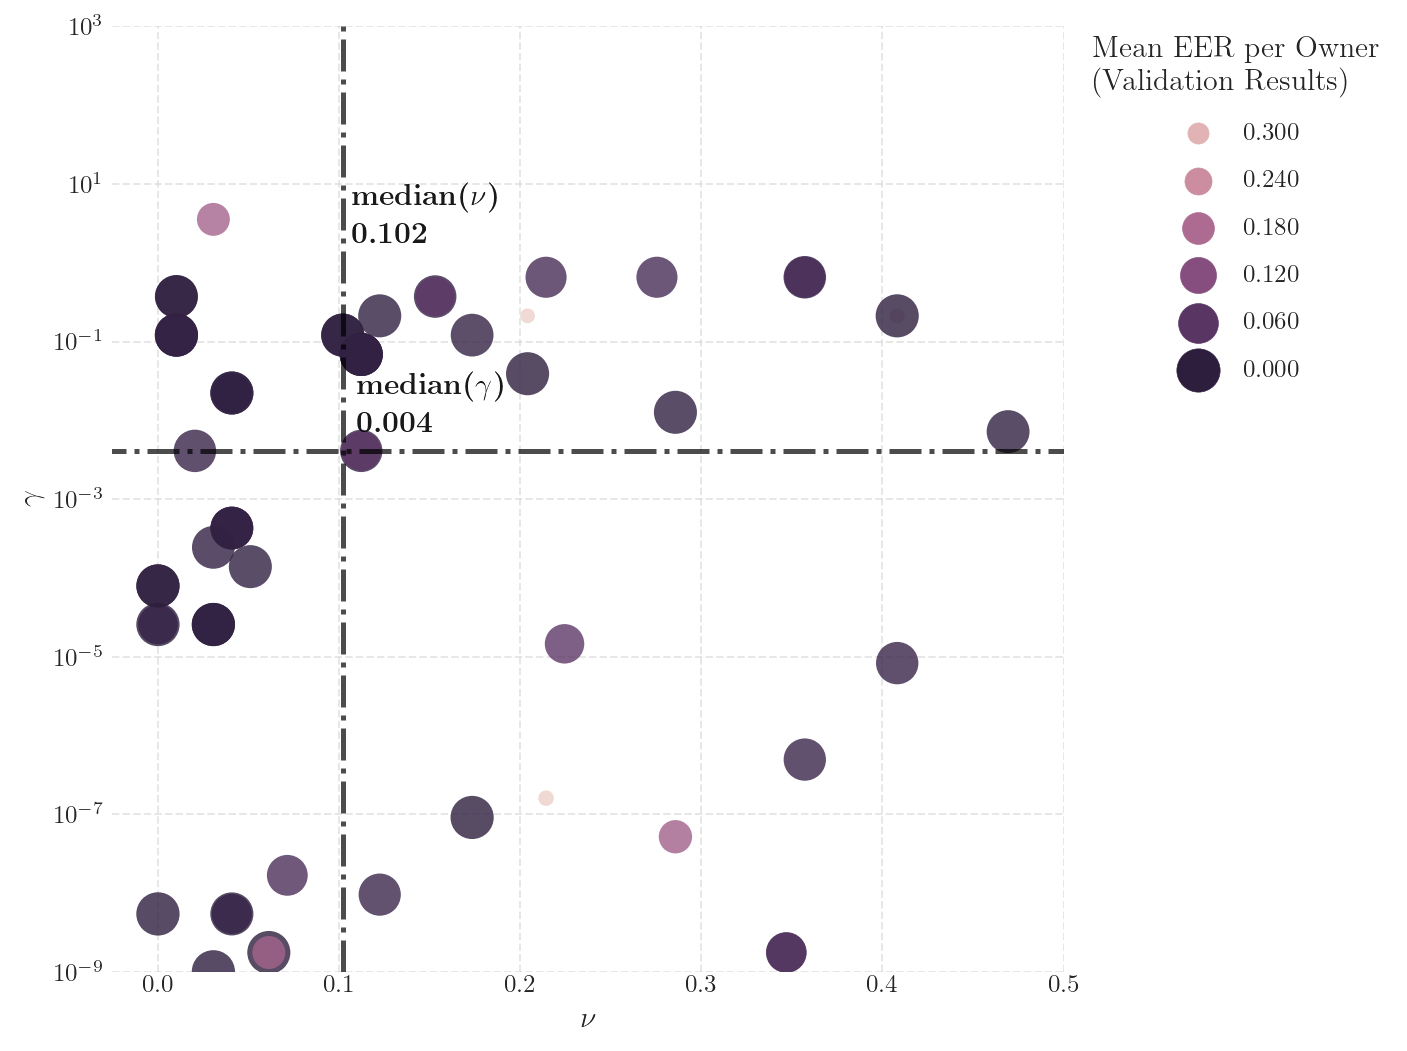

In [18]:
result_dict = utils_plot_randomsearch_results(df_results, n_top=1, h1_min_max_scale_tuple=(-.025, .5, "linear"), h2_min_max_scale_tuple=(1e-9, 1e3, "log"), plot=True)
P.ocsvm_nu, P.ocsvm_gamma, fig = result_dict["median_nu"], result_dict["median_gamma"], result_dict["fig"]
P.ocsvm_nu, P.ocsvm_gamma
# plt.savefig(f"./thesis_tables_and_figures/WACA-OCSVM-Nu_Gamma_plot-win_size={P.window_size}-step_width={P.ocsvm_step_width}-smoothing:{P.smoothing}.svg", format="svg", bbox_inches='tight')

In [ ]:
result_dict = utils_plot_randomsearch_results(df_results, n_top=1, plot=True)
P.ocsvm_nu, P.ocsvm_gamma, fig = result_dict["median_nu"], result_dict["median_gamma"], result_dict["fig"]
P.ocsvm_nu, P.ocsvm_gamma

0, −0.20
1, −0.16
2, −0.12
3, −0.08
4, −0.04
5, 0.00
['0.200', '0.160', '0.120', '0.080', '0.040', '0.000']


(0.03577857142857143, 0.039069399370546126)

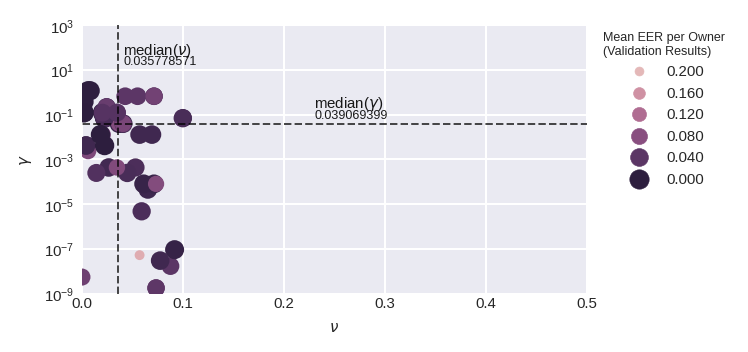

In [98]:
result_dict = utils_plot_randomsearch_results(df_results, n_top=1, plot=True)
P.ocsvm_nu, P.ocsvm_gamma, fig = result_dict["median_nu"], result_dict["median_gamma"], result_dict["fig"]
P.ocsvm_nu, P.ocsvm_gamma

0, $\mathdefault{−0.25}$
-0.25
1, $\mathdefault{−0.20}$
-0.2
2, $\mathdefault{−0.15}$
-0.15
3, $\mathdefault{−0.10}$
-0.1
4, $\mathdefault{−0.05}$
-0.05
5, $\mathdefault{0.00}$
0.0
['$\\mathdefault{0.25}$', '$\\mathdefault{0.20}$', '$\\mathdefault{0.15}$', '$\\mathdefault{0.10}$', '$\\mathdefault{0.05}$', '$\\mathdefault{0.00}$']


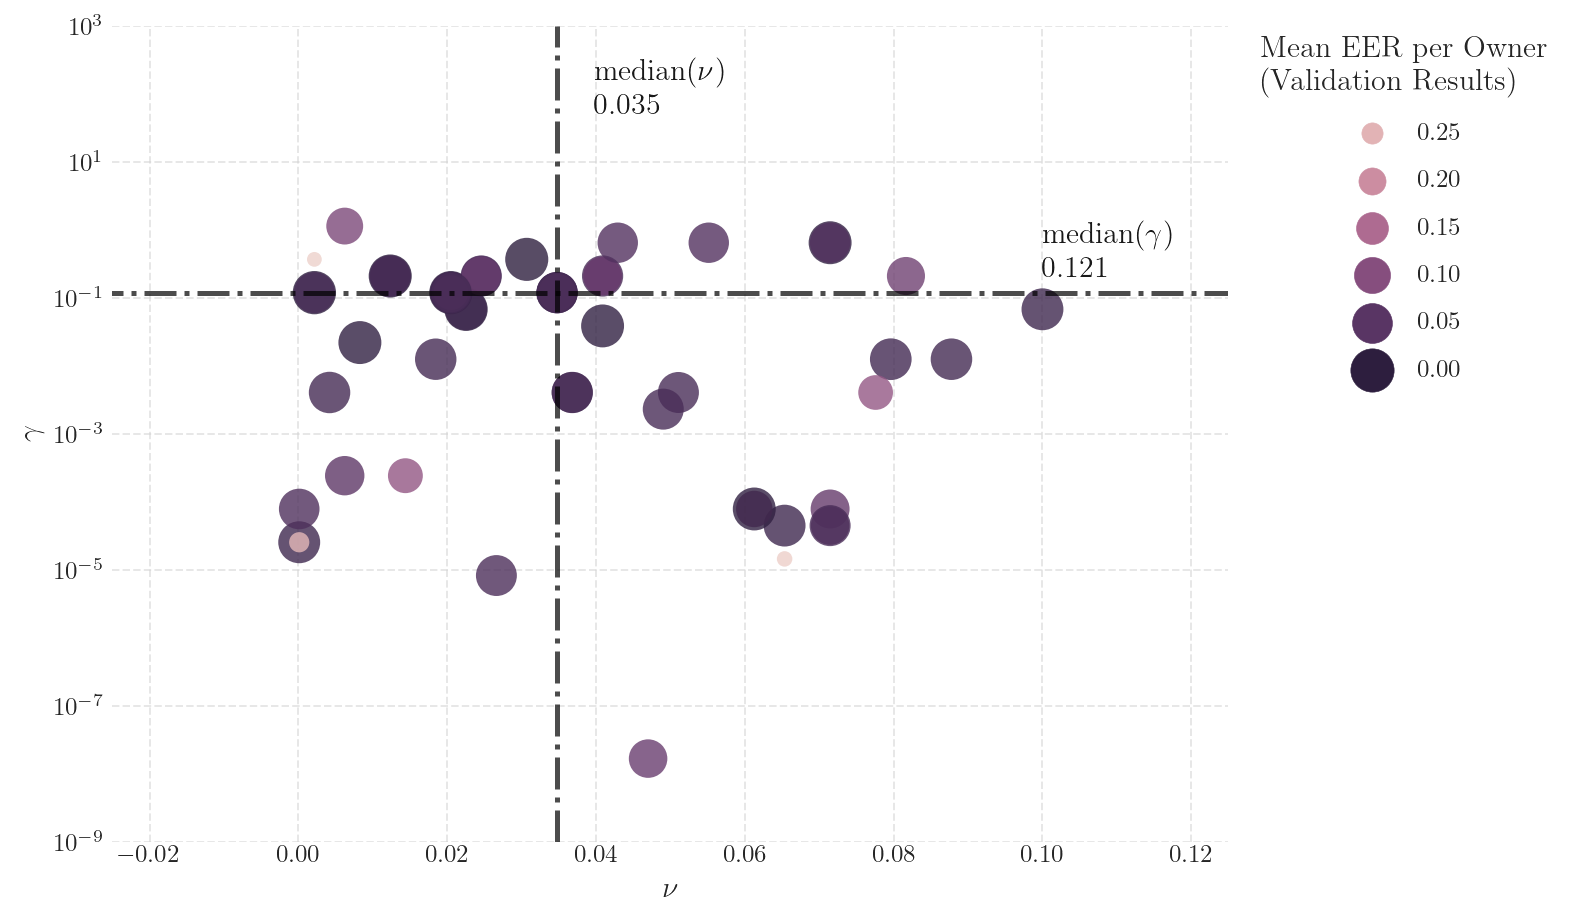

In [191]:

# _, _, fig = utils_plot_randomsearch_results(df_results, n_top=1)
P.ocsvm_nu, P.ocsvm_gamma, fig = utils_plot_randomsearch_results(df_results[(df_results.rank_test_eer == 1) & (df_results.mean_test_eer < 0.5)], n_top=1, h1_min_max_scale_tuple=(-.025, .125, "linear"), h2_min_max_scale_tuple=(1e-9, 1e3, "log"), plot=True)
plt.savefig(f'WACA-OCSVM-Nu_Gamma_plot-win_size={P.window_size}-step_width={P.ocsvm_step_width}-smoothing:{P.smoothing}.svg', bbox_inches='tight')

In [74]:
fig.savefig(f'WACA-OCSVM-Nu_Gamma_plot-win_size={P.window_size}-step_width={P.ocsvm_step_width}-smoothing:{P.smoothing}.svg', bbox_inches='tight')

AttributeError: 'str' object has no attribute 'savefig'

In [77]:
print(f"P.ocsvm_nu={P.ocsvm_nu}, P.ocsvm_gamma={P.ocsvm_gamma}")

P.ocsvm_nu=0.053108163265306124, P.ocsvm_gamma=0.00042919342601287783


In [ ]:
print(f"P.ocsvm_nu={P.ocsvm_nu}, P.ocsvm_gamma={P.ocsvm_gamma}")

In [161]:
df_results[(df_results.rank_test_eer == 1) & (df_results.mean_test_eer != 0.5)].groupby('owner').head(232)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__nu,param_model__gamma,24_test_eer,8_test_eer,11_test_eer,13_test_eer,19_test_eer,28_test_eer,21_test_eer,26_test_eer,3_test_eer,20_test_eer,22_test_eer,6_test_eer,25_test_eer,16_test_eer,1_test_eer,17_test_eer,27_test_eer,5_test_eer,29_test_eer,mean_test_eer,std_test_eer,rank_test_eer,24_test_accuracy,8_test_accuracy,11_test_accuracy,13_test_accuracy,19_test_accuracy,28_test_accuracy,21_test_accuracy,26_test_accuracy,3_test_accuracy,20_test_accuracy,22_test_accuracy,6_test_accuracy,25_test_accuracy,16_test_accuracy,1_test_accuracy,17_test_accuracy,27_test_accuracy,5_test_accuracy,29_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,7_test_eer,7_test_accuracy
49,0.000616,0.000011,0.000844,0.000019,0.000816,0.039069,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.000000e+00,1,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600000,0.000000,1,7,0,NaN,NaN
94,0.000607,0.000020,0.000858,0.000085,0.000724,0.012649,NaN,0.230769,0.250000,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.231781,4.294171e-03,1,NaN,0.850,0.800,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.847368,0.011165,1,24,0,0.230769,0.850
109,0.000607,0.000014,0.000851,0.000093,0.000522,0.012649,NaN,0.230769,0.250000,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.231781,4.294171e-03,1,NaN,0.850,0.800,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.847368,0.011165,1,24,0,0.230769,0.850
229,0.000623,0.000036,0.000907,0.000140,0.000945,0.007197,0.240000,NaN,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.416667,0.240000,0.230769,0.230769,0.230769,0.240000,0.255206,6.740451e-02,1,0.825,NaN,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.600,0.825,0.850,0.850,0.850,0.825,0.815789,0.088187,1,8,0,0.481481,0.525
289,0.000620,0.000014,0.000842,0.000026,0.000816,0.039069,0.487179,0.487179,NaN,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,5.551115e-17,1,0.525,0.525,NaN,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525000,0.000000,1,11,0,0.487179,0.525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4590,0.000612,0.000013,0.000950,0.000401,0.000945,0.007197,0.428571,0.428571,0.428571,0.428571,0.428571,0.441176,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.441176,0.428571,0.428571,0.428571,NaN,0.428571,0.428571,0.429898,3.868389e-03,1,0.625,0.625,0.625,0.625,0.625,0.600,0.625,0.625,0.625,0.625,0.625,0.625,0.600,0.625,0.625,0.625,NaN,0.625,0.625,0.622368,0.007672,1,27,2,0.428571,0.625
4651,0.000626,0.000013,0.000843,0.000023,0.000651,0.068665,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,NaN,0.487179,0.487179,5.551115e-17,1,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,NaN,0.525,0.525000,0.000000,1,5,2,0.487179,0.525
4669,0.000623,0.000013,0.000842,0.000026,0.000559,0.068665,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,Na

In [55]:
X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, window_size, step_width, test_set, P.scaler, P.num_sample_points_per_exp, 
                                                                                    EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize, Butter_per_win_argdict=P.Butter_per_win_argdict)


X_exp_test_dic = extract_WACA_features(X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict, scaler_clip=False)

len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  2.2562748277559876
MakeWACAXExpDicUnknown Time:  5.68843318335712
Done extracting features


In [56]:
import time
    
elapsed_time_dict={}

# elapsed_time_dict=
# {1: 1.1274936199188232,
#  2: 1.0859317779541016,
#  3: 1.1646921634674072,
#  4: 1.2141354084014893,
#  5: 1.2444705963134766,
#  6: 1.2584974765777588,
#  7: 1.295924186706543,
#  8: 1.3720738887786865,
#  9: 1.3679378032684326,
#  10: 1.328564167022705,
#  11: 1.379624605178833,
#  12: 1.3409805297851562,
#  13: 1.379106044769287,
#  14: 1.3944427967071533,
#  15: 1.423699140548706,
#  16: 1.354649543762207,
#  17: 1.3932619094848633,
#  18: 1.3947765827178955,
#  19: 1.371302604675293}
for cores in range(2, 3):
    start_time = time.time()
    
    test_df_results = None  # Will be filled with randomsearch scores
    for run in tqdm(range(5)):

        with parallel_backend('loky', n_jobs=-1):
            df_score = Parallel(n_jobs=-1, verbose=0)(delayed(evaluate_owner_classifier_train_test)(owner_key, X_exp_test_dic, SEED, run, cores=cores, exp_config=P, verbose=0) 
                                                               for owner_key in tqdm(X_exp_test_dic.keys(),
                                                                                     desc=f"run: {run}",
                                                                                    ))
        test_df_results = pd.concat([test_df_results] + df_score, sort=False, ignore_index=True, axis=0)
    
    elapsed_time = time.time() - start_time
    elapsed_time_dict[cores]=elapsed_time
    print(f"Elapsed time: {elapsed_time} seconds")
    

100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

Elapsed time: 2.2705514430999756 seconds


In [57]:
elapsed_time_dict

{2: 2.2705514430999756}

In [58]:
evaluate_owner_classifier_train_test(12, X_exp_test_dic, SEED, run, cores=CORES, exp_config=P, verbose=1) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


,fit_time,score_time,test_eer,test_accuracy,test_precision,test_recall,test_f1_score,owner,run,impostors
0,0.002977,0.014146,0.804878,0.195122,0.195122,0.195122,0.195122,12,4,0
1,0.002959,0.008296,0.243902,0.756098,0.756098,0.756098,0.756098,12,4,14
2,0.002819,0.007921,0.109756,0.890244,0.900000,0.878049,0.888889,12,4,9
3,0.002924,0.006005,0.646341,0.353659,0.357143,0.365854,0.361446,12,4,18
4,0.002800,0.005810,0.841463,0.158537,0.150000,0.146341,0.148148,12,4,23
5,0.002993,0.008392,0.304878,0.695122,0.700000,0.682927,0.691358,12,4,2
6,0.001545,0.008797,0.621951,0.378049,0.375000,0.365854,0.370370,12,4,15
7,0.001731,0.006669,0.146341,0.853659,0.853659,0.853659,0.853659,12,4,10
8,0.002426,0.009353,0.500000,0.500000,0.500000,0.512195,0.506024,12,4,4


In [59]:
# df_score

In [60]:
ow, im = 23, 15
print(test_df_results[(test_df_results.owner==ow) & (test_df_results.impostors==im)][["test_eer"]].mean())
test_df_results[(test_df_results.owner==ow) & (test_df_results.impostors==im)][["test_eer"]]

test_eer    0.085366
dtype: float64


,test_eer
51,0.085366
141,0.085366
231,0.085366
321,0.085366
411,0.085366


In [61]:
print(test_df_results.shape)
groupted_df = test_df_results.groupby(['owner', 'impostors', 'run'])["test_eer"].mean()
groupted_df.shape
# for group_name, group_df in groupted_df:
#     print(f"Group: {group_name}")
#     # print(group_df)
#     print()

(450, 10)


(450,)

In [62]:
mean_test_EER=test_df_results.groupby(['owner', 'impostors'])['test_eer'].mean().reset_index()

In [63]:
test_df_results[63:72]

,fit_time,score_time,test_eer,test_accuracy,test_precision,test_recall,test_f1_score,owner,run,impostors
63,0.005829,0.010499,0.024390,0.975610,1.000000,0.951220,0.975000,15,0,0
64,0.005658,0.023161,0.256098,0.743902,0.750000,0.731707,0.740741,15,0,12
65,0.004048,0.006173,0.024390,0.975610,1.000000,0.951220,0.975000,15,0,14
66,0.002044,0.012742,0.024390,0.975610,1.000000,0.951220,0.975000,15,0,9
67,0.003943,0.013953,0.024390,0.975610,1.000000,0.951220,0.975000,15,0,18
68,0.001345,0.009933,0.085366,0.914634,0.947368,0.878049,0.911392,15,0,23
69,0.002269,0.012326,0.024390,0.975610,1.000000,0.951220,0.975000,15,0,2
70,0.001418,0.011377,0.024390,0.975610,1.000000,0.951220,0.975000,15,0,10
71,0.001427,0.006572,0.158537,0.841463,0.833333,0.853659,0.843373,15,0,4


In [64]:
test_df_results[test_df_results.test_precision==0]

,fit_time,score_time,test_eer,test_accuracy,test_precision,test_recall,test_f1_score,owner,run,impostors


In [65]:
test_df_results.test_precision[test_df_results.test_precision==0]

Series([], Name: test_precision, dtype: float64)

In [66]:
# mean_test_EER=test_df_results.groupby(['owner', 'impostors'], sort=False)[['fit_time', 'score_time', 'test_eer', 'train_eer', 'test_accuracy', 
#                                                                            'train_accuracy', 'test_precision', 'train_precision', 'test_recall',
#                                                                            'train_recall']].mean().reset_index()

mean_test_EER=test_df_results.groupby(['owner', 'impostors'], sort=False)[['fit_time', 'score_time', 'test_eer', 'test_accuracy', 
                                                                           'test_precision', 'test_recall', "test_f1_score"]].mean().reset_index()

In [67]:
mean_test_EER.test_eer.mean()

0.08842818428184275

In [68]:
test_df_plot = mean_test_EER.rename(
    columns={"test_f1_score": "Test F1_score","test_recall": "Test Recall" , "test_precision": "Test Precision", "test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "owner"}
).astype({"owner": str})
test_df_plot

,owner,impostors,fit_time,score_time,Test EER,Test Accuracy,Test Precision,Test Recall,Test F1_score
0,0,12,0.004310,0.012893,0.000000,1.000000,1.000000,1.000000,1.000000
1,0,14,0.004694,0.015443,0.000000,1.000000,1.000000,1.000000,1.000000
2,0,9,0.002321,0.010002,0.000000,1.000000,1.000000,1.000000,1.000000
3,0,18,0.002340,0.012891,0.000000,1.000000,1.000000,1.000000,1.000000
4,0,23,0.002101,0.010566,0.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
85,4,18,0.002330,0.015564,0.073171,0.926829,0.926829,0.926829,0.926829
86,4,23,0.001475,0.012990,0.109756,0.890244,0.900000,0.878049,0.888889
87,4,2,0.001936,0.010470,0.036585,0.963415,1.000000,0.926829,0.962025
88,4,15,0.001497,0.011171,0.256098,0.743902,0.750000,0.731707,0.740741


/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Overall mean: 0.0884


/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Overall mean: 0.9116


/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Overall mean: 0.9262


/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Overall mean: 0.8965


/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Overall mean: 0.9099


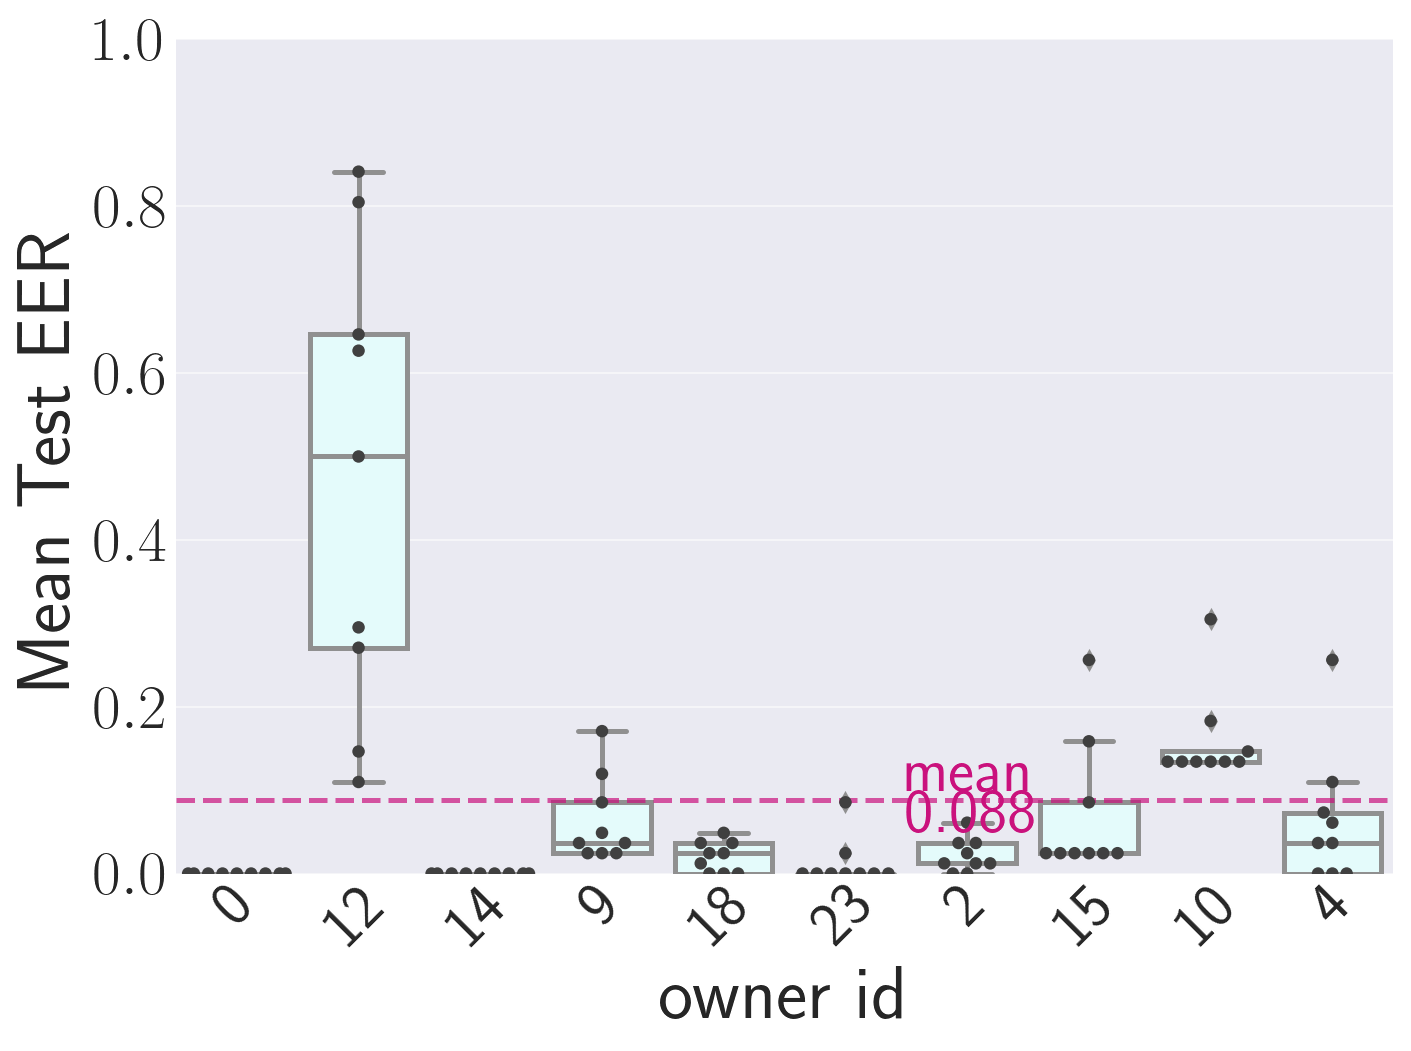

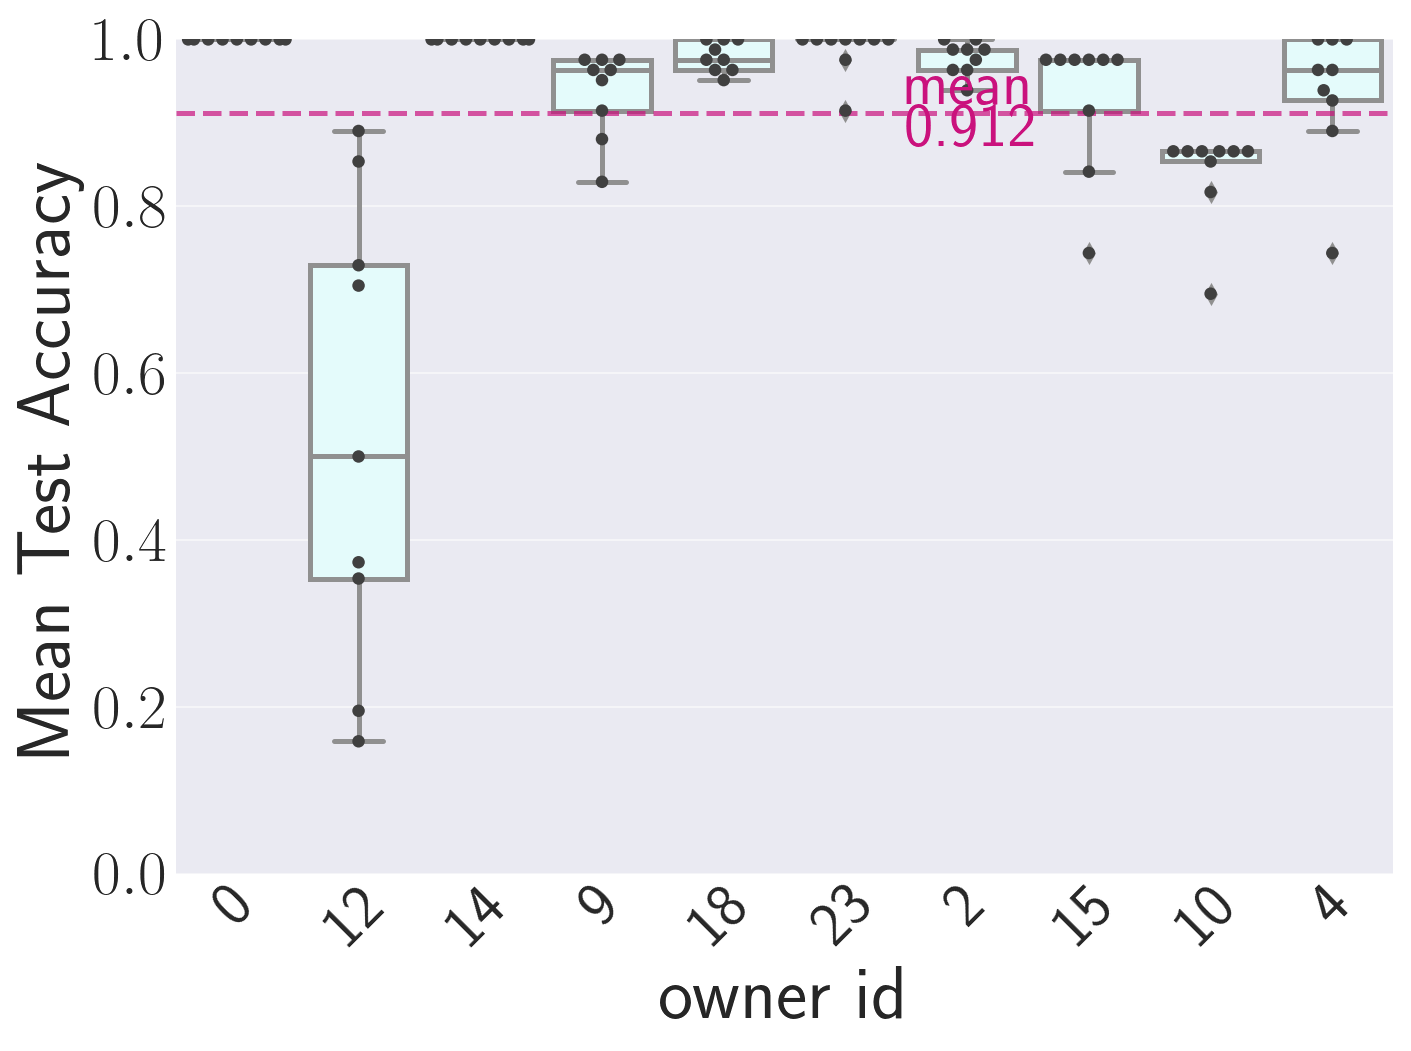

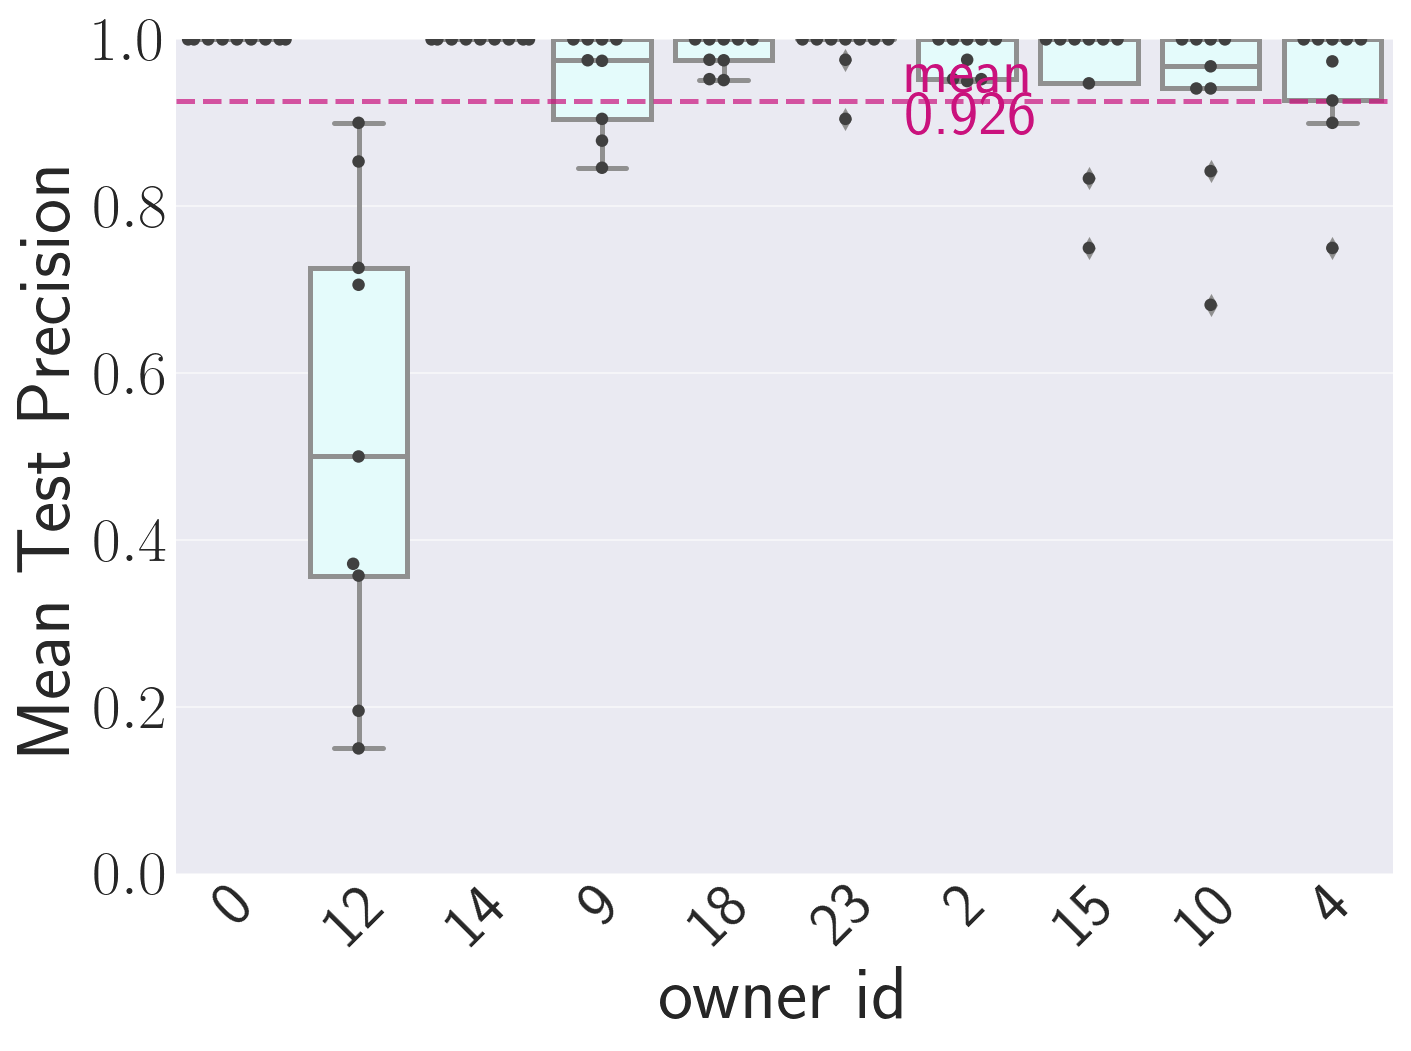

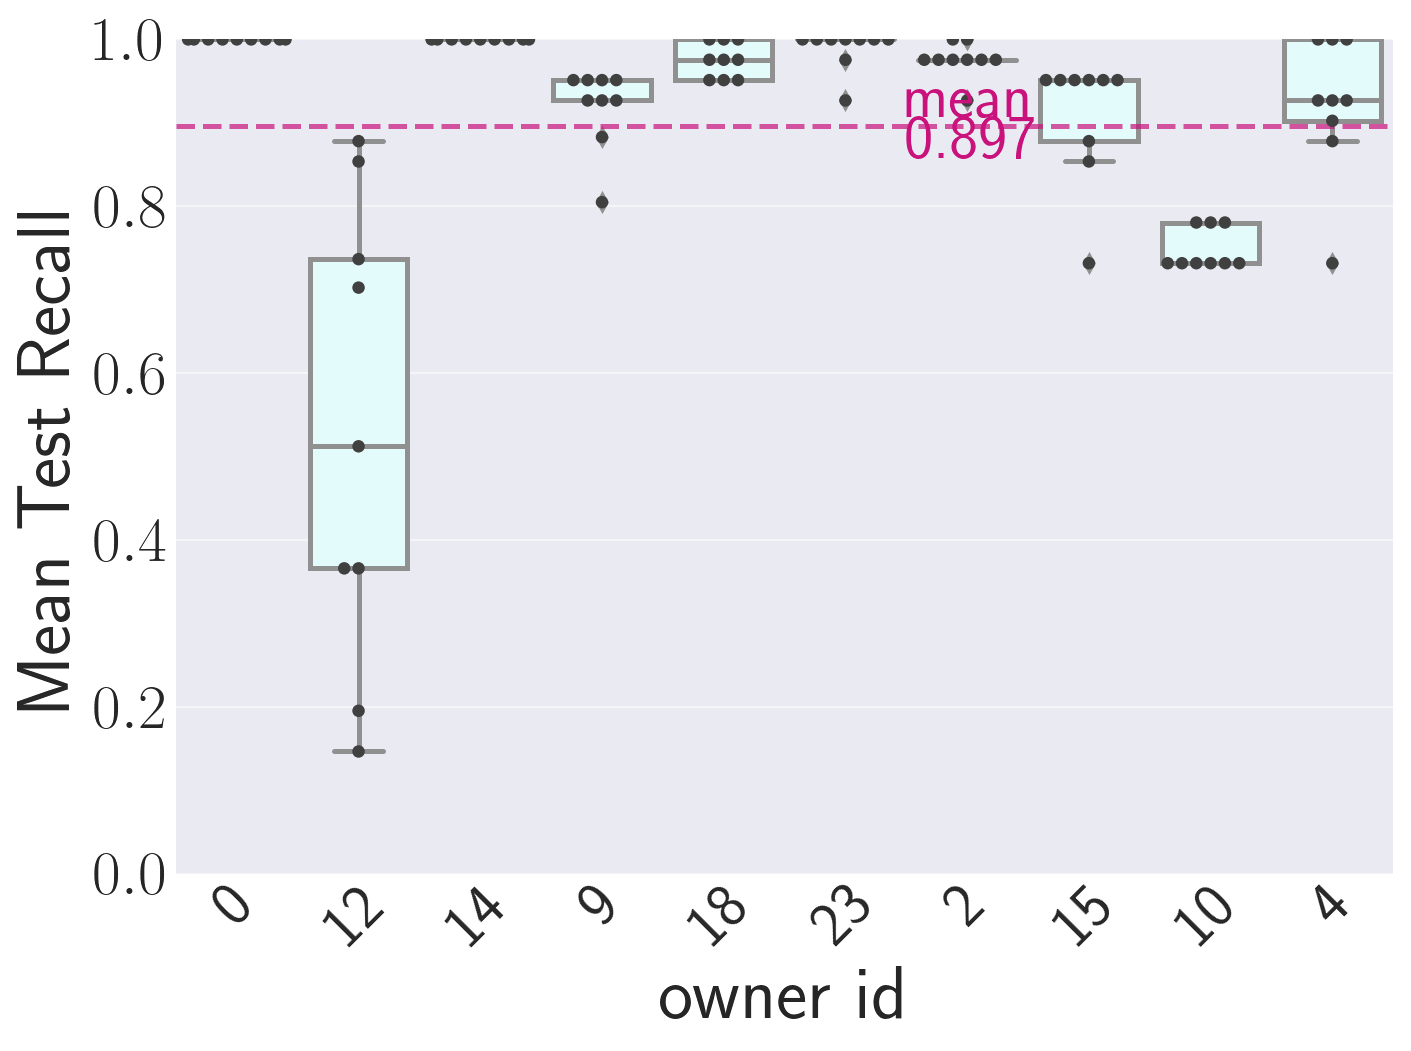

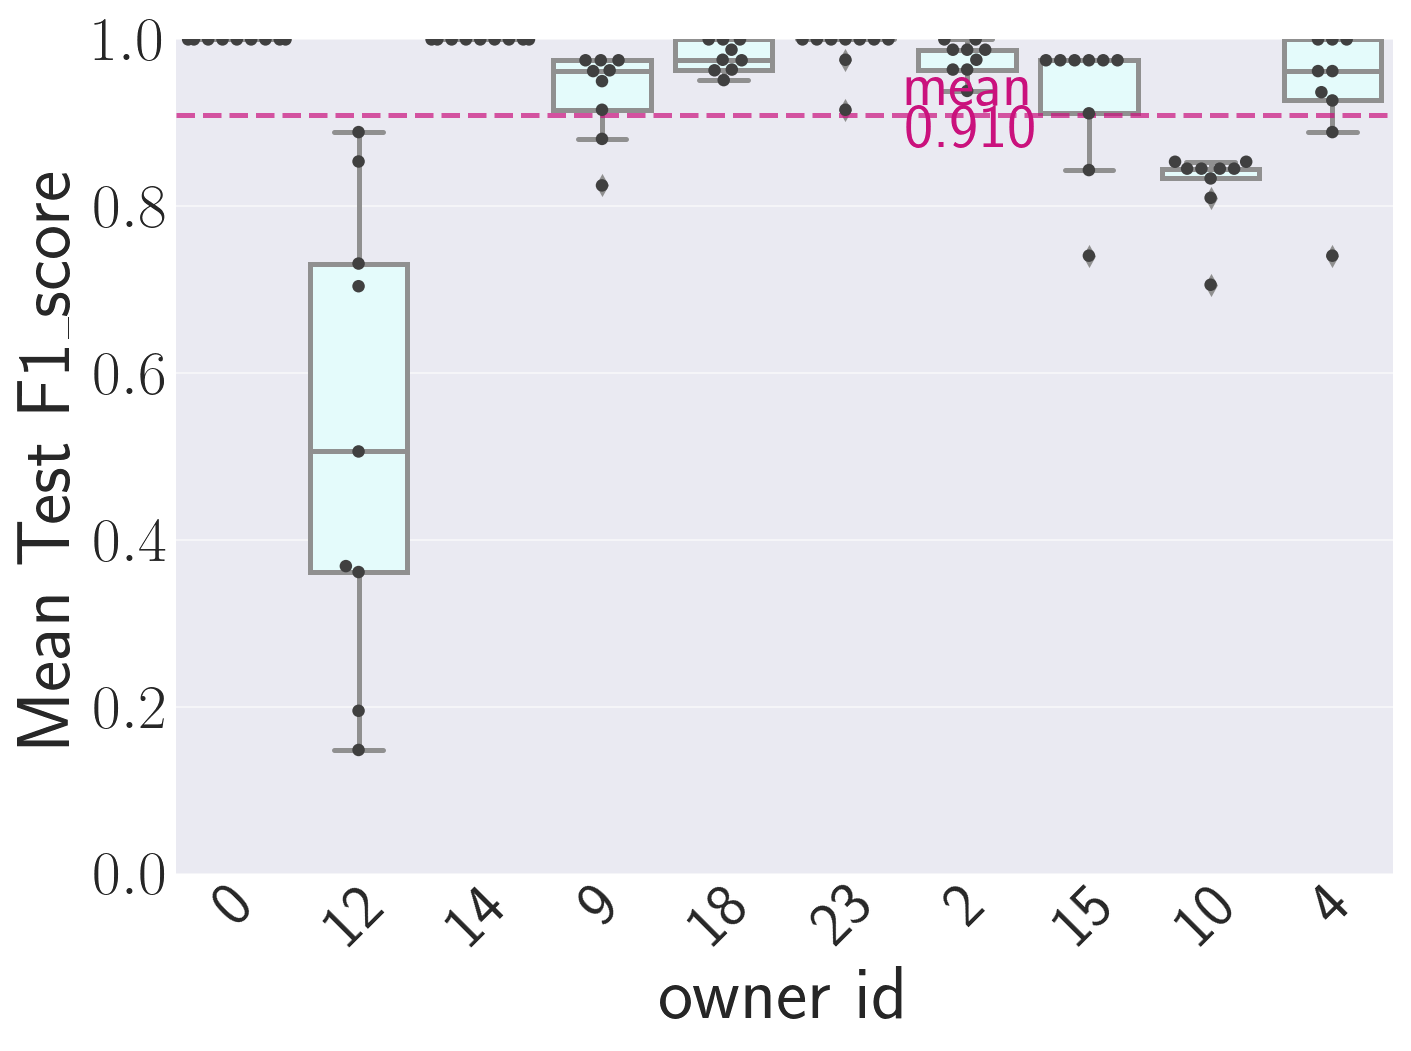

In [72]:
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test EER', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_EER.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Accuracy', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Precision', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Recall', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test F1_score', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")

# %run ./SEED-CONSTANTS.ipynb

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Overall mean: 0.0884


/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Overall mean: 0.9116


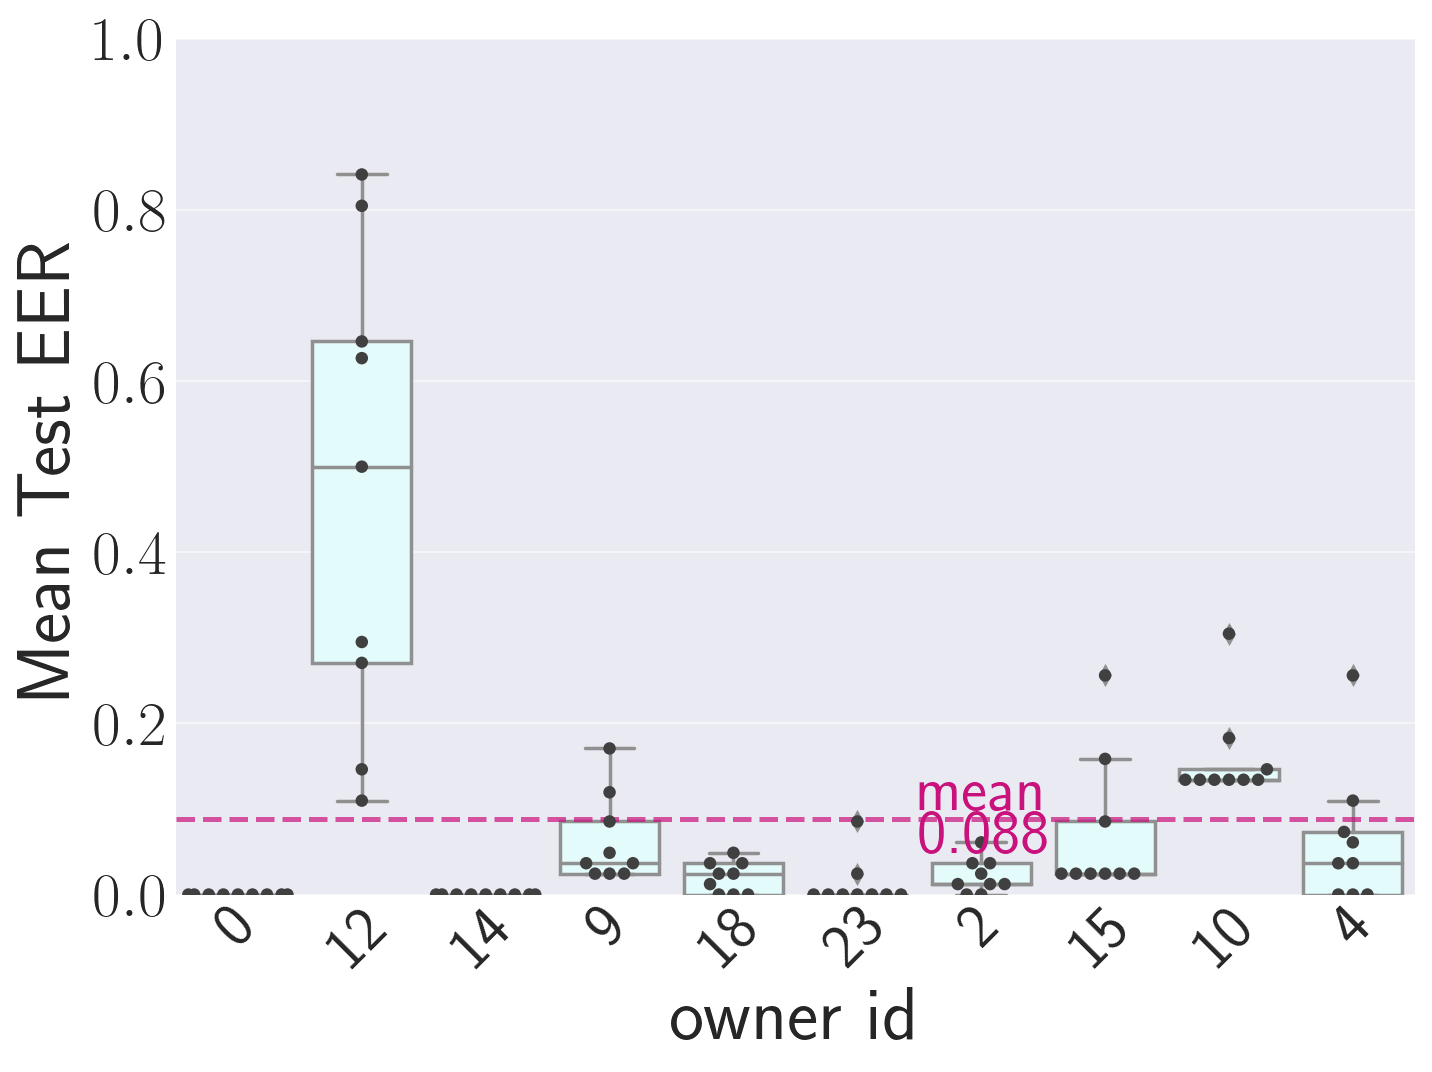

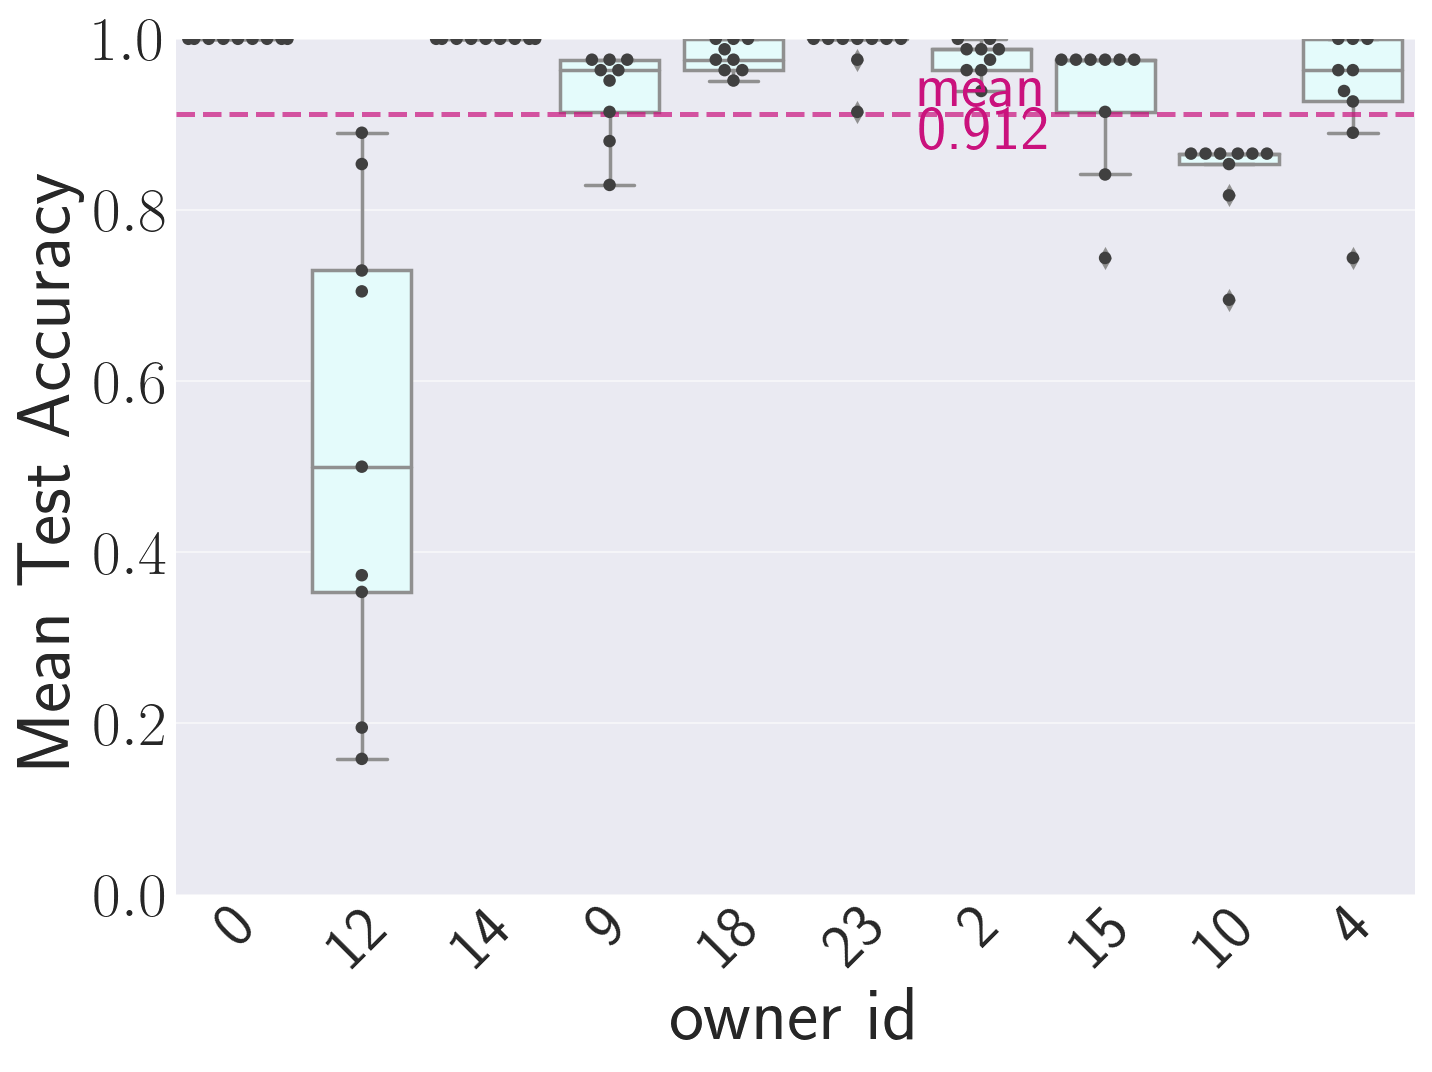

SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------


In [70]:
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test EER', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_EER.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Accuracy', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
%run ./SEED-CONSTANTS.ipynb


Overall mean: 0.3516
Overall mean: 0.7076


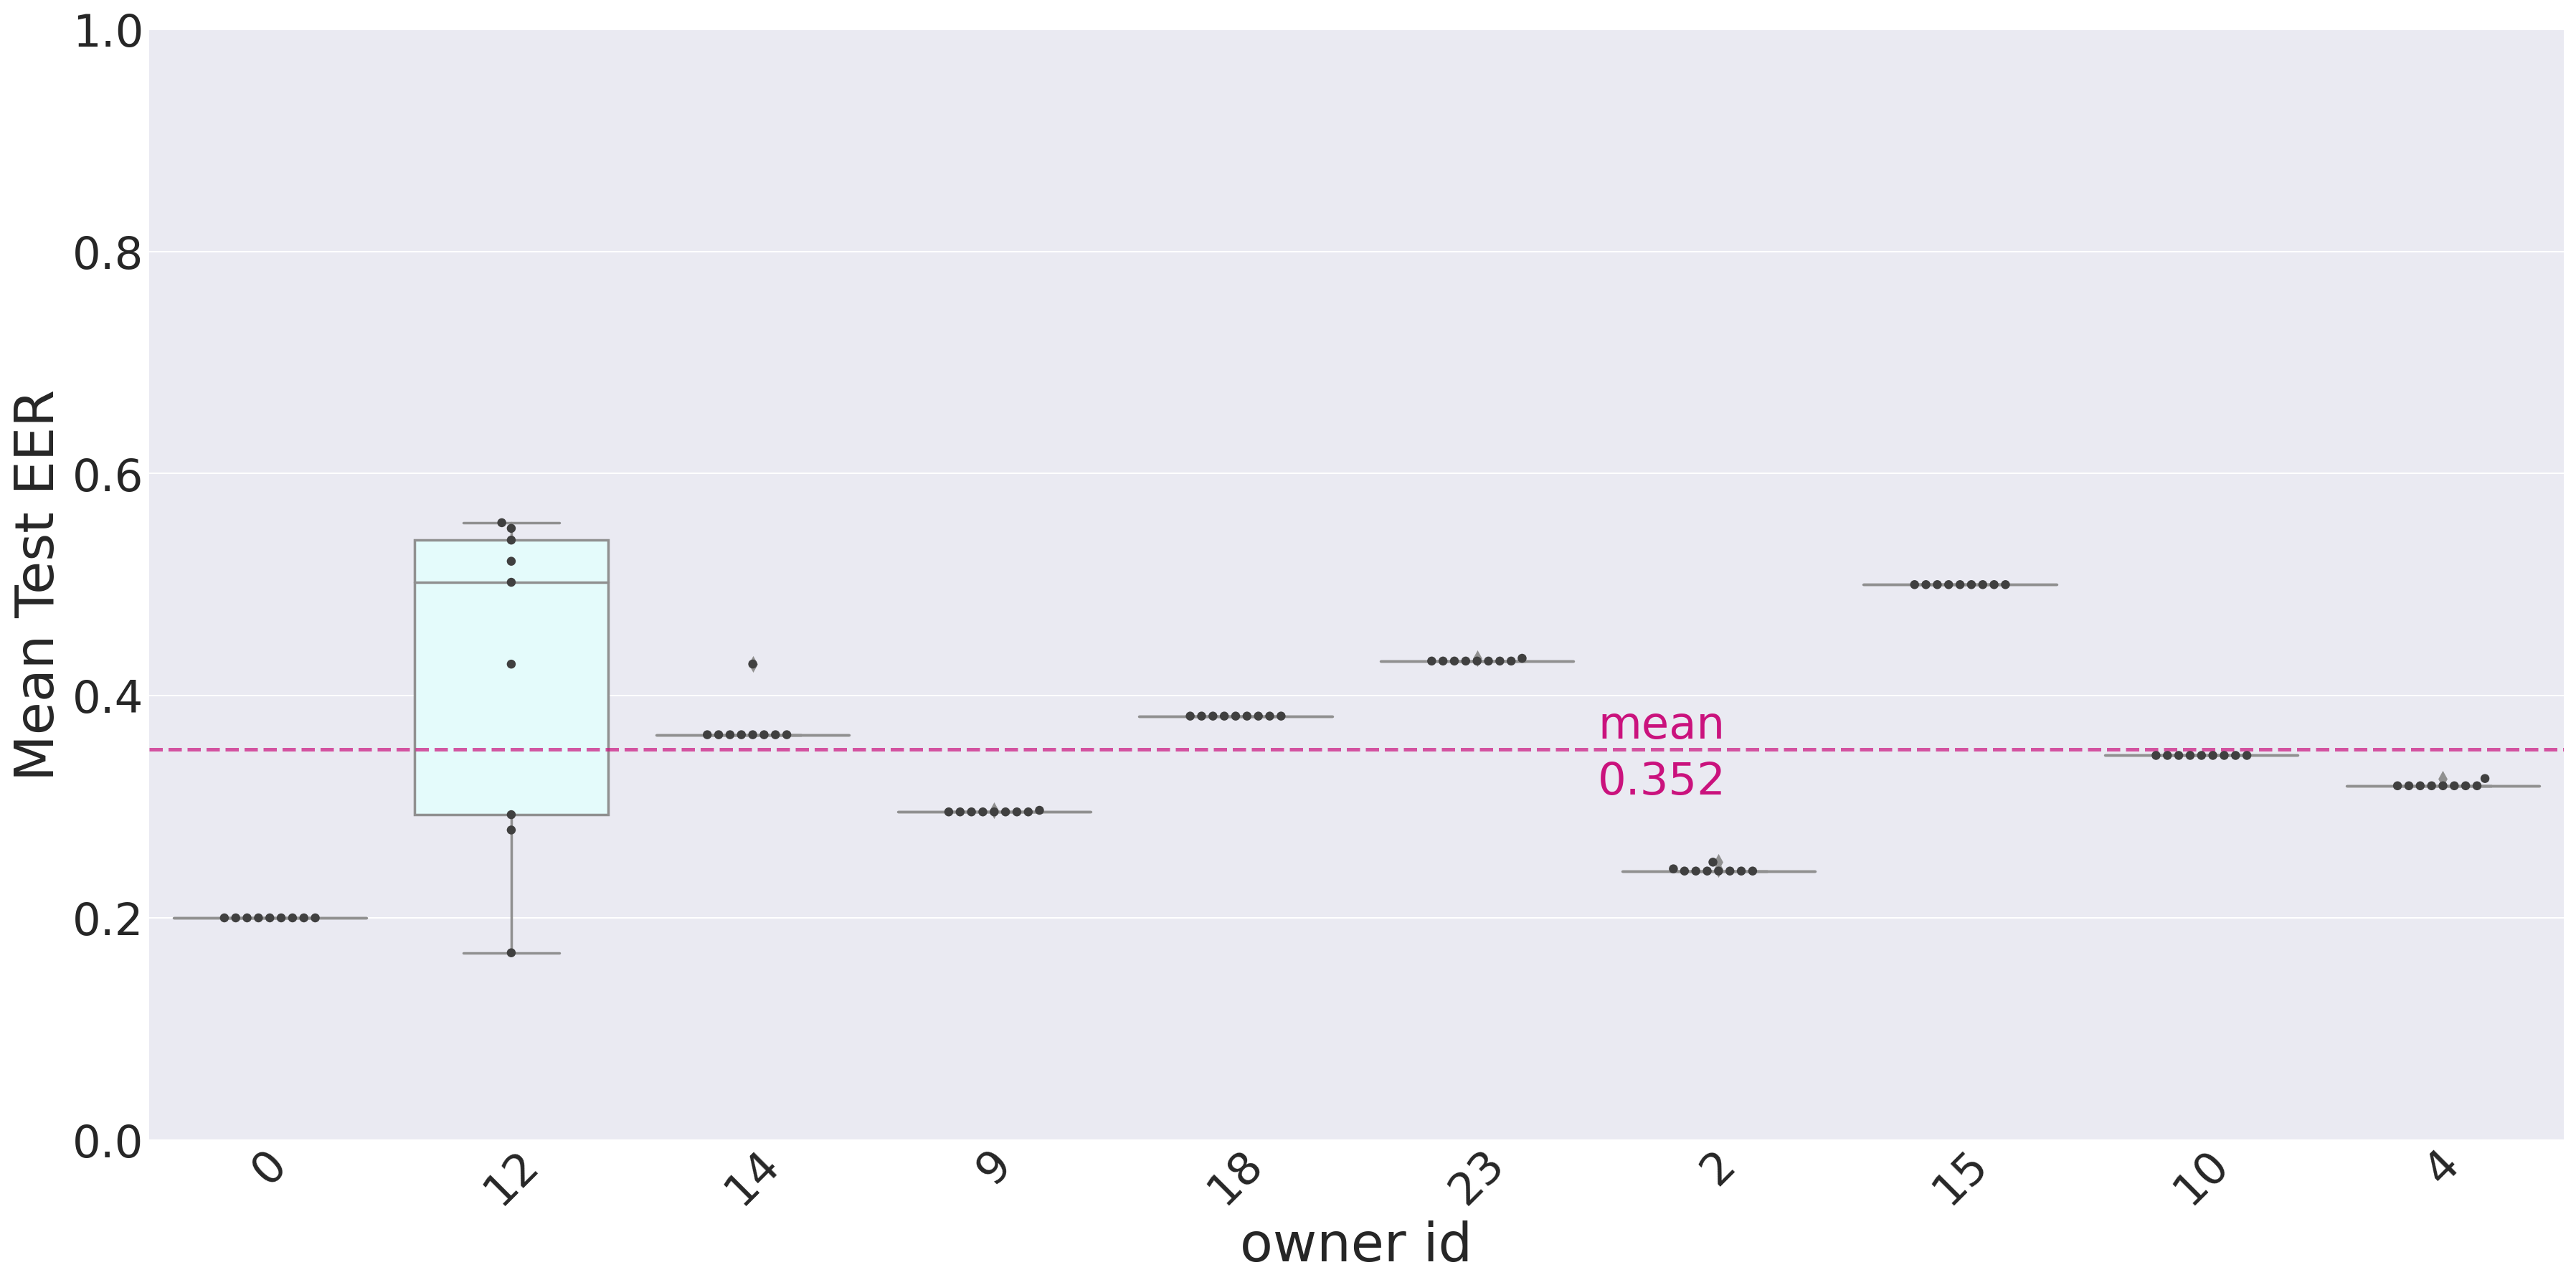

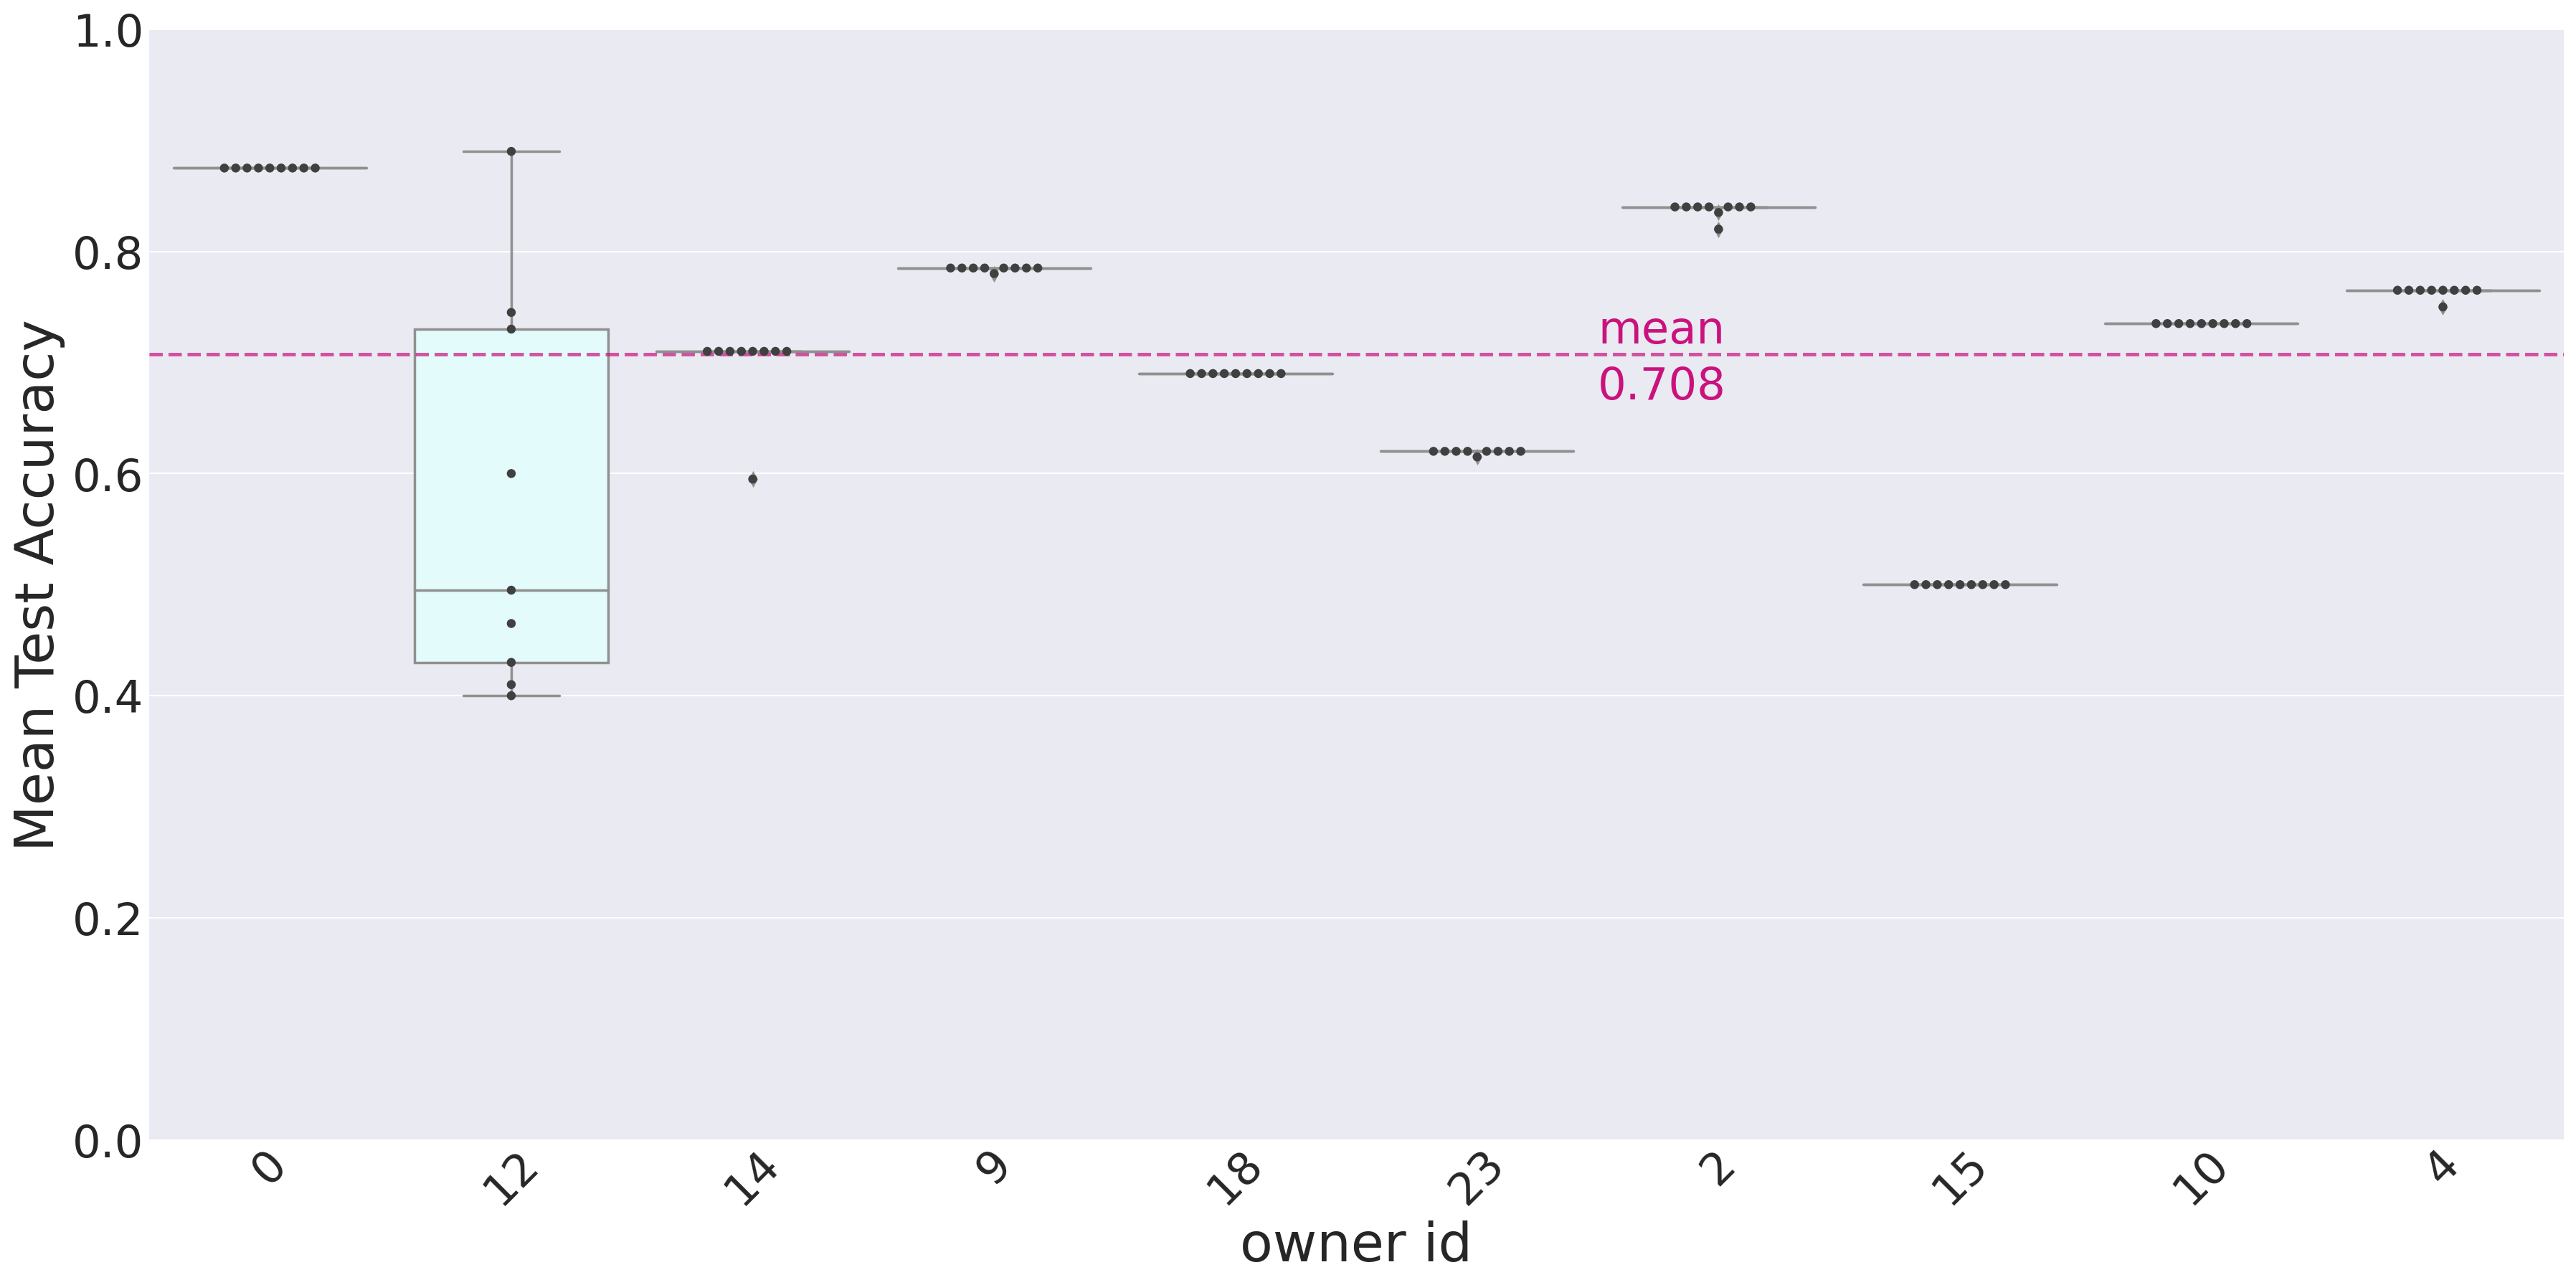

SEED: 567
--------------------SEED and CONSTANTS imported--------------------


In [66]:
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test EER', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_EER.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Accuracy', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
%run ./SEED-CONSTANTS.ipynb


0.3437499308804177


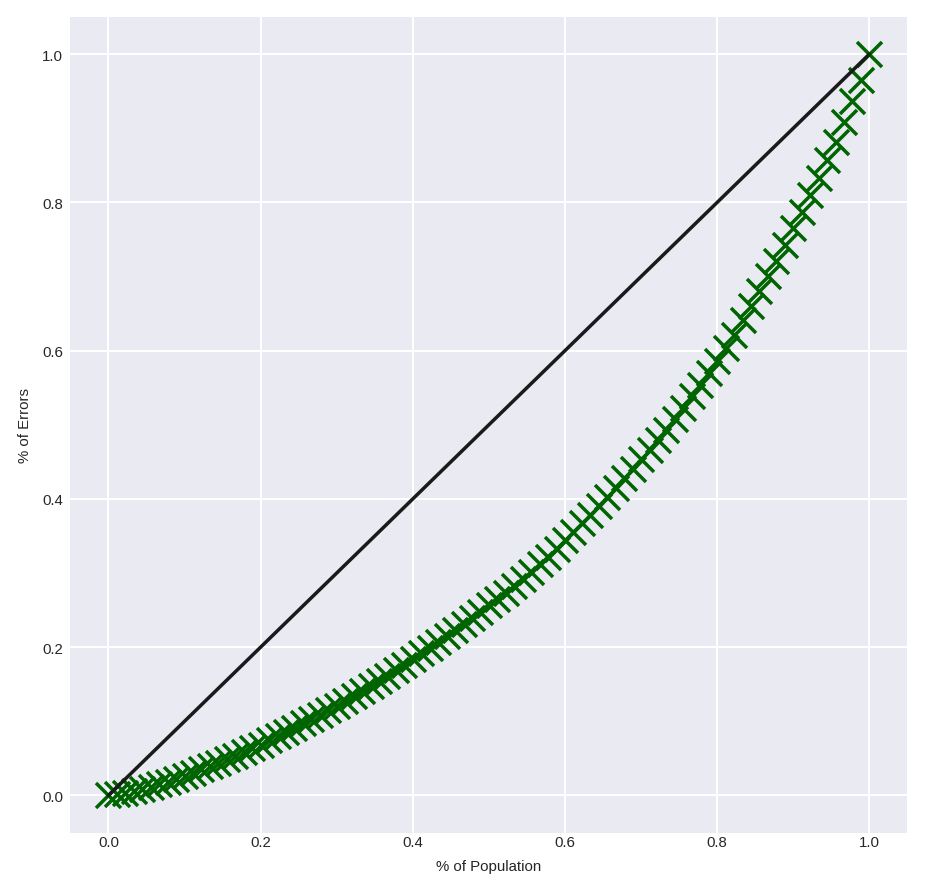

In [477]:
print(gini(test_df_plot['Test EER'].to_numpy()))
lorenz_curve(test_df_plot['Test EER'].to_numpy())